# Notebook for plotting figures for generalized KT

## import libraries, and fix plot setting

In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
from scipy.spatial.distance import pdist

import pathlib
import os
import os.path
import pickle as pkl

# Fitting linear models
import statsmodels.api as sm
from scipy.stats import multivariate_normal

# plottibg libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
import seaborn as sns
plt.style.use('seaborn-white')

# utils for generating samples, evaluating kernels, and mmds
from util_sample import sample, compute_mcmc_params_p, compute_diag_mog_params, sample_string, compute_params_p
from util_k_mmd import kernel_eval, p_kernel, ppn_kernel, pp_kernel, pnpn_kernel, squared_mmd, get_combined_results_filename, compute_params_k
from util_parse import init_parser, convert_arg_flags


# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [2]:
fix_plot_settings = True
if fix_plot_settings:
    plt.rc('font', family='serif')
    plt.rc('text', usetex=False)
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['axes.labelsize'] = label_size
    mpl.rcParams['axes.titlesize'] = label_size
    mpl.rcParams['figure.titlesize'] = label_size
    mpl.rcParams['lines.markersize'] = label_size
    mpl.rcParams['grid.linewidth'] = 2.5
    mpl.rcParams['legend.fontsize'] = label_size
    pylab.rcParams['xtick.major.pad']=5
    pylab.rcParams['ytick.major.pad']=5

    lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
    mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
    ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
    colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']
else:
    pass

## 0.2 Define helper functions for loading / plotting mmds; and loading input / coresets

In [57]:
def load_combined_results(args,
                          keys = ["mmd_p", "mmd_sin", "fundiff_p", "fundiff_sin"],
                          generic_prefixes = ["-combinedmmd-", "-sin-combinedmmd-", "-combinedfundiff-", "-sin-combinedfundiff-"],
                          delta=0.5, 
                         ):
    """
    Return dictionary of mmd and fun_diff results
    
    args: dictionary of arguemnts
    keys: quantities to be plotted
    generic_prefixes: list of str for loading results
    delta: error parameter
    """
   

    results_dict = dict()
    for key in keys:
        results_dict[key] = dict()

    d, params_p, var_k =  compute_params_p(args)
    params_k, params_k_power = compute_params_k(args, var_k, args.computepower, args.power)
    
    ms = range(args.m)
    rep_ids = np.arange(args.rep0, args.rep0+args.repn)
    
    if args.ktplus:
        assert(args.power is not None)
        params_k_combo = dict()
        params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
        params_k_combo["k"] = params_k.copy()
        params_k_combo["kpower"] = params_k_power.copy()
        params_k_combo["var"] = params_k["var"]
        params_k_combo["d"] = args.d   
    
    # load monte carlo / standard thinning results
    if args.stdthin:
        prefixes = ["mc" + prefix for prefix in generic_prefixes]
        for prefix, key in zip(prefixes, keys):
            filename = get_combined_results_filename(prefix, ms, params_p, params_k, params_k, rep_ids, delta)
            print(filename)
            tag = 'iid' if params_p["name"] in ["gauss", "diag_mog"] else 'standard'
            with open(filename, 'rb') as file:
                results_dict[key][tag] = pkl.load(file)

    # load KT power results     
    if args.powerkt:
        temp = "kt_krt" if args.power == 0.5 else f"kt_power{args.power}"
        prefixes = [temp + prefix for prefix in generic_prefixes]
        lab_suffix = "(rt)" if args.power == 0.5 else "(%.2f)"%(args.power)
        for prefix, key in zip(prefixes, keys):
            filename = get_combined_results_filename(prefix, ms, params_p, params_k_split=params_k_power, params_k_swap=params_k, rep_ids=rep_ids, delta=delta)
            with open(filename, 'rb') as file:
                results_dict[key][f"KT{lab_suffix}"] = pkl.load(file)
    
    # load target KT          
    if args.targetkt:
        prefixes = ["kt" + prefix for prefix in generic_prefixes]
        for prefix, key in zip(prefixes, keys):
            filename = get_combined_results_filename(prefix, ms, params_p, params_k_split=params_k, params_k_swap=params_k, rep_ids=rep_ids, delta=delta)
            print(filename)
            with open(filename, 'rb') as file:
                results_dict[key]["KT"] = pkl.load(file)
    
    # load kt+
    if args.ktplus:
        prefixes = [f"kt-plus{args.power}" + prefix for prefix in generic_prefixes]
        for prefix, key in zip(prefixes, keys):
            filename = get_combined_results_filename(prefix, ms, params_p, params_k_split=params_k_combo, params_k_swap=params_k, rep_ids=rep_ids, delta=delta)
            with open(filename, 'rb') as file:
                results_dict[key]["KT+"] = pkl.load(file)
            
    return(results_dict)


def load_function_approx_results(args, fun_strs = ["k0"], delta=0.5
                                ):
    """
    Return dictionary of fun results
    
    args: dictionary of arguments
    fun_strs: name of functions to be loaded (only functions allowed in evaluate_single_function_notebook)
    delta: error parameter
    """
    
    d, params_p, var_k =  compute_params_p(args)
    params_k, params_k_power = compute_params_k(args, var_k, args.computepower, args.power)
    
    ms = range(args.m)
    rep_ids = np.arange(args.rep0, args.rep0+args.repn)
    
    if args.ktplus:
        assert(args.power is not None)
        params_k_combo = dict()
        params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
        params_k_combo["k"] = params_k.copy()
        params_k_combo["kpower"] = params_k_power.copy()
        params_k_combo["var"] = params_k["var"]
        params_k_combo["d"] = args.d   
        
    results_dict = dict()
    keys = ["fundiff_p", "fundiff_sin"]
    for fun_str in fun_strs:
        new_fun_str = "" if fun_str == 'k0' else fun_str
        generic_prefixes = [f"-combinedfundiff{new_fun_str}-", f"-sin-combinedfundiff{new_fun_str}-"]
        results_dict[fun_str] = dict()
        for key in keys:
            results_dict[fun_str][key] = dict()
            
        if args.stdthin:
            # load monte carlo results
            # temp fix since we are not running all kt variants, and stdthin errenously takes kernel params in its name; TBD FIX PROPERLY
            if args.targetkt:
                k_split, k_swap = params_k, params_k
            elif args.ktplus:
                k_split, k_swap = params_k_combo, params_k
            else:
                raise ValueError(f"Unclear which kernel name to use for loading ST results")
                
            prefixes = ["mc" + prefix for prefix in generic_prefixes]
            for prefix, key in zip(prefixes, keys):
                filename = get_combined_results_filename(prefix, ms, params_p, k_split, k_swap, rep_ids, delta)
                tag = 'iid' if params_p["name"] in ["gauss", "diag_mog"] else 'standard'
                with open(filename, 'rb') as file:
                    results_dict[fun_str][key][tag] = pkl.load(file)

                    
        if args.targetkt:    
            prefixes = ["kt" + prefix for prefix in generic_prefixes]
            for prefix, key in zip(prefixes, keys):
                filename = get_combined_results_filename(prefix, ms, params_p, params_k_split=params_k, params_k_swap=params_k, rep_ids=rep_ids, delta=delta)
                with open(filename, 'rb') as file:
                    results_dict[fun_str][key]["KT"] = pkl.load(file)

        # load KT with krt results
        if args.powerkt:
            prefixes = ["kt" + prefix for prefix in generic_prefixes]
            lab_suffix = "(rt)" if args.power == 0.5 else "(%.2f)"%(args.power)
            for prefix, key in zip(prefixes, keys):
                filename = get_combined_results_filename(prefix, ms, params_p, params_k_split=params_k_power, params_k_swap=params_k, rep_ids=rep_ids, delta=delta)
                with open(filename, 'rb') as file:
                    results_dict[fun_str][key][f"KT{lab_suffix}"] = pkl.load(file)
                    
        # load KT plus
        if args.ktplus:
            prefixes = [f"kt-plus" + prefix for prefix in generic_prefixes]      
            for prefix, key in zip(prefixes, keys):
                filename = get_combined_results_filename(prefix, ms, params_p, params_k_split=params_k_combo, params_k_swap=params_k, rep_ids=rep_ids, delta=delta)
                with open(filename, 'rb') as file:
                    results_dict[fun_str][key]["KT+"] = pkl.load(file)
         
        
    return(results_dict)


In [58]:
def load_input_and_coreset(m, params_p, params_k_split, params_k_swap, rep_id, thin_str="", delta=0.5, 
                      sample_seed=1234567, thin_seed=9876543, results_dir="results_new", verbose=False):
    """Return exisiting coresets by loading from disk, and the associated MC points used for finding the coresets
    if return_ktplus = True, return the KTplus coresets.
    
    Args:
      m: Number of halving rounds (number of sample points n = 2^{2m})
      params_p: Dictionary of distribution parameters recognized by sample()
      params_k_split: Dictionary of kernel parameters recognized by kernel() # used for kt split
      params_k_swap: Dictionary of kernel parameters recognized by kernel() # used for kt swap; and computing mmd
      rep_id: A single rep id for which coreset to be returned
      thin_str: (Optional), str to be appended to filenames when loading coresets other than KT and iid/ST, e.g., kt.split + rand
      delta: If c is None, delta/(4^m) is the failure probability for
        adaptive threshold sequence
      sample_seed: (Optional) random seed is set to sample_seed + rep
        prior to generating input sample for replication rep
      thin_seed: (Optional) random seed is set to thin_seed + rep
        prior to running thinning for replication rep
      results_dir: (Optional) Directory in which results is to be loaded from
      verbose: (Optional) If True, print intermediate updates
    """
    
    d = params_p["d"]
    assert(d == params_k_split["d"])
    assert(d == params_k_swap["d"])
    sample_str = sample_string(params_p, sample_seed)
    split_kernel_str = "{}_var{:.3f}_seed{}".format(params_k_split["name"], params_k_split["var"], thin_seed)
    swap_kernel_str =  "{}_var{:.3f}".format(params_k_swap["name"], params_k_swap["var"])
    thresh_str = f"delta{delta}"
    file_template = os.path.join(results_dir, f"kt{thin_str}-coresets-{sample_str}-split{split_kernel_str}-swap{swap_kernel_str}-d{d}-m{m}-{thresh_str}-rep{{}}.pkl")
    
    filename = file_template.format(rep_id)
    n = int(2**(2*m))
    ncoreset = int(2**m)
    X = sample(n, params_p, seed=sample_seed+rep_id)
    if os.path.exists(filename):
        with open(filename, 'rb') as file:
            if verbose:
                print(f"Loading KT coreset indices from {filename}")
            coresets = pkl.load(file)
    else:
        raise ValueError(f"File {filename} not found")

    if verbose:
        print(f"Returning all {n} input MC points and {ncoreset} KT points")
    return(X, X[coresets[:ncoreset]])

In [59]:
    
def plot_mmd_dict(axes, ms, mmds_dict, size_factor=1., fit_model=True, error_bar = True, error_shade = False, skip_ns=int(0),
                  legend_size= 30,#mpl.rcParams['legend.fontsize'],
                  label_kt = 'Target KT', #None,
                  label_kt_rt = 'Root KT', #None,
                  rm_keys = [], summary=np.mean, legend_loc = 'best', basex=4, basey=4,
                  standard_label="standard",
                 plot_keys=None):
    '''
        Plot mmd rates
        axes: axes objet for a matplotlib figure
        ms: array of integers denoting the logarithmic range of coreset size (m=log_2 coreset size)
        mmds_dict: Dictionary of mmd rates; each entry should have size Rep x len(ms)
        size_factor: Float, scaling of marker size
        fit_model: Whether fit a log-log least squares model
        error_bar: Boolean, When true error bars across Reps are plotted for each key in mmds_dict
        error_shade: Boolean, When true shaded error regions are be plotted for each key in mmds_dict
        skip_ns: Integer, starting index for the plot (how many entries to skip in ms, and mmds_dict keys)
        legend_size: Size of the legend in the plot
        rm_keys: keys not to be plotted
        summary: function to be used for combining results across reps
        legend_loc: location of legend
        standard_label: legend for standard thinning
        label_kt: legend for target KT
        label_kt_rt: legend for root KT
        plot_keys: specific list of keys to be plotted (only subset of this will be plotted if not None)
        
    '''
    ns = np.power(4, ms[skip_ns:], dtype=int)
    X = sm.add_constant(np.log(ns))
    ls = []
    labs = []
    mmds_dict_new = mmds_dict.copy()
    for rm_key in rm_keys:
        mmds_dict_new.pop(rm_key, None)
        
    # remove keys that are not to be plotted
    keys = list(mmds_dict_new.keys())
    if plot_keys is not None:
        for key in keys:
            if key not in plot_keys:
                mmds_dict_new.pop(key, None)

    for i, (label, mmd) in enumerate(mmds_dict_new.items()):
        #if (plot_keys is not None and label in plot_keys) or (plot_keys is None):
        if summary == np.mean or summary == np.nanmedian:
            y = summary(mmd, axis=1)
            yerr = np.nanstd(mmd, axis=1) / np.sqrt((~np.isnan(mmd)).sum(axis=1))
            y = y[skip_ns:]
            yerr = yerr[skip_ns:]
        else:
            y = mmd
            yerr = np.zeros_like(y)

        if fit_model:
            model = sm.OLS(np.log(y), X).fit()

        if not(error_bar) and not(error_shade):
            l1, = axes.plot(ns, y, marker=mss[i], linestyle='None', 
                           color=colors[i], alpha=1., markersize=size_factor*ms_size[i])

        else:
            if error_bar:
                l1 = axes.errorbar(ns, y, marker=mss[i], yerr=np.array([np.zeros_like(yerr), yerr]), linestyle='None', 
                            color=colors[i], alpha=1., markersize=size_factor*ms_size[i], linewidth=5)
            if error_shade:
                axes.fill_between(ns, y-yerr, y+yerr, alpha=0.2, color=colors[i])

        if fit_model:
            l2, = axes.plot(ns, np.exp(model.predict(X)),
                                   linestyle=lss[i],
                                   linewidth=4, color=colors[i], alpha=.5)

        if label=="standard":
            label = standard_label
        if label== "KT" and label_kt is not None:
            label = label_kt
            
        if label== "KT(rt)" and label_kt_rt is not None:
            label = label_kt_rt
            
        if fit_model:
            
            labs.append(label.replace("_", " ") + r": n$^{%.2f}$"%(model.params[1]))
            ls.append((l1, l2))
        else:
            labs.append(label.replace("_", " "))
            ls.append((l1))
        
        
        axes.legend(ls, labs, loc=legend_loc, handletextpad=0.0, fontsize=legend_size)
        axes.set_xscale('log', base=basex)
        axes.set_yscale('log', base=basey)
        axes.spines['top'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        axes.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        axes.grid(True, alpha=0.4)
    return

# basic set-up

In [60]:

all_generic_prefixes = ["-combinedmmd-", "-sin-combinedmmd-", "-combinedfundiff-", "-sin-combinedfundiff-"],
all_keys = ["mmd_p", "mmd_sin", "fundiff_p", "fundiff_sin"]
fig_dir = "../generalized_kt/figs/"

In [61]:
mmd_results = dict()
fun_results = dict()
fun_strs = ["x", "kernel", "cif"] # other possibilities: "x", "cov", "pk"] # "l1_x", "linf_x", "x^2", "x1x2"]

In [62]:
# if isnotebook():
parser = init_parser()
args, opt = parser.parse_known_args()
args = convert_arg_flags(args)

In [63]:
ylab_size = 22
xlab_size = 22
title_size = 25
leg_size = 22
ms_factor = 1.2
x_lab  = r"Input size $n$"

# Gauss Plot

In [64]:
run_gauss_experiments = True

In [68]:
generic_prefixes = ["-combinedmmd-"]
keys = ["mmd_p"]

args.rerun = False
args.kernel = "gauss"
args.P = "gauss"
args.rep0 = 0
args.repn = 10
args.m = 7+1         

args.computepower = True
args.power = 0.5
args.targetkt = True
args.powerkt = True
args.stdthin = True
args.ktplus = False

ms = range(args.m)

In [70]:
ds =  [2, 10, 20, 50, 100]
# if 100 in ds:
#     args.computepower = False
#     args.power = 0.5
#     args.ktplus = False
#     args.powerkt = False
     
if run_gauss_experiments:
    for d in ds:
        args.d = d
        print(f"loading results for {args.kernel} kernel and {args.P} P in d={d} till m ={args.m}")
        mmd_results[f"{args.P}-{args.d}"] = load_combined_results(args, keys, generic_prefixes)
        args.powerkt = False
        fun_results[f"{args.P}-{args.d}"] = load_function_approx_results(args, 
                                 fun_strs = fun_strs)

loading results for gauss kernel and gauss P in d=2 till m =8
results_new/combined/mc-combinedmmd--gauss_var1.0_seed1234567--split_gauss_var4.0_seed9876543-swap_gauss_var4.0-d2-m7-delta0.5-rep10.pkl
results_new/combined/kt-combinedmmd--gauss_var1.0_seed1234567--split_gauss_var4.0_seed9876543-swap_gauss_var4.0-d2-m7-delta0.5-rep10.pkl
loading results for gauss kernel and gauss P in d=10 till m =8
results_new/combined/mc-combinedmmd--gauss_var1.0_seed1234567--split_gauss_var20.0_seed9876543-swap_gauss_var20.0-d10-m7-delta0.5-rep10.pkl
results_new/combined/kt-combinedmmd--gauss_var1.0_seed1234567--split_gauss_var20.0_seed9876543-swap_gauss_var20.0-d10-m7-delta0.5-rep10.pkl
loading results for gauss kernel and gauss P in d=20 till m =8
results_new/combined/mc-combinedmmd--gauss_var1.0_seed1234567--split_gauss_var40.0_seed9876543-swap_gauss_var40.0-d20-m7-delta0.5-rep10.pkl
results_new/combined/kt-combinedmmd--gauss_var1.0_seed1234567--split_gauss_var40.0_seed9876543-swap_gauss_var40.0-d20-

## d as columns

In [71]:
mmd_labels = ["$MMD_{\\bf k}(\\mathbb{P}, \\mathbb{P}_{out})$"]

fun_strs =  ['x', 'kernel', 'cif']
fun_latex = ['x_1', "\mathbf{k}(X')", 'f_{CIF}'] 
fun_diff_key = ['fundiff_p', 'fundiff_p', 'fundiff_sin']

fun_y_labels = [] 

for f, k, latex in zip(fun_strs, fun_diff_key, fun_latex):
    if 'p' in k:
        fun_y_labels.append(r"$|(\mathbb{P} - \mathbb{P}_{out})  %s|$"% latex)
    else:
        fun_y_labels.append(r"$|(\mathbb{P}_{in} - \mathbb{P}_{out})  %s|$"% latex)

In [72]:
leg_size = 24

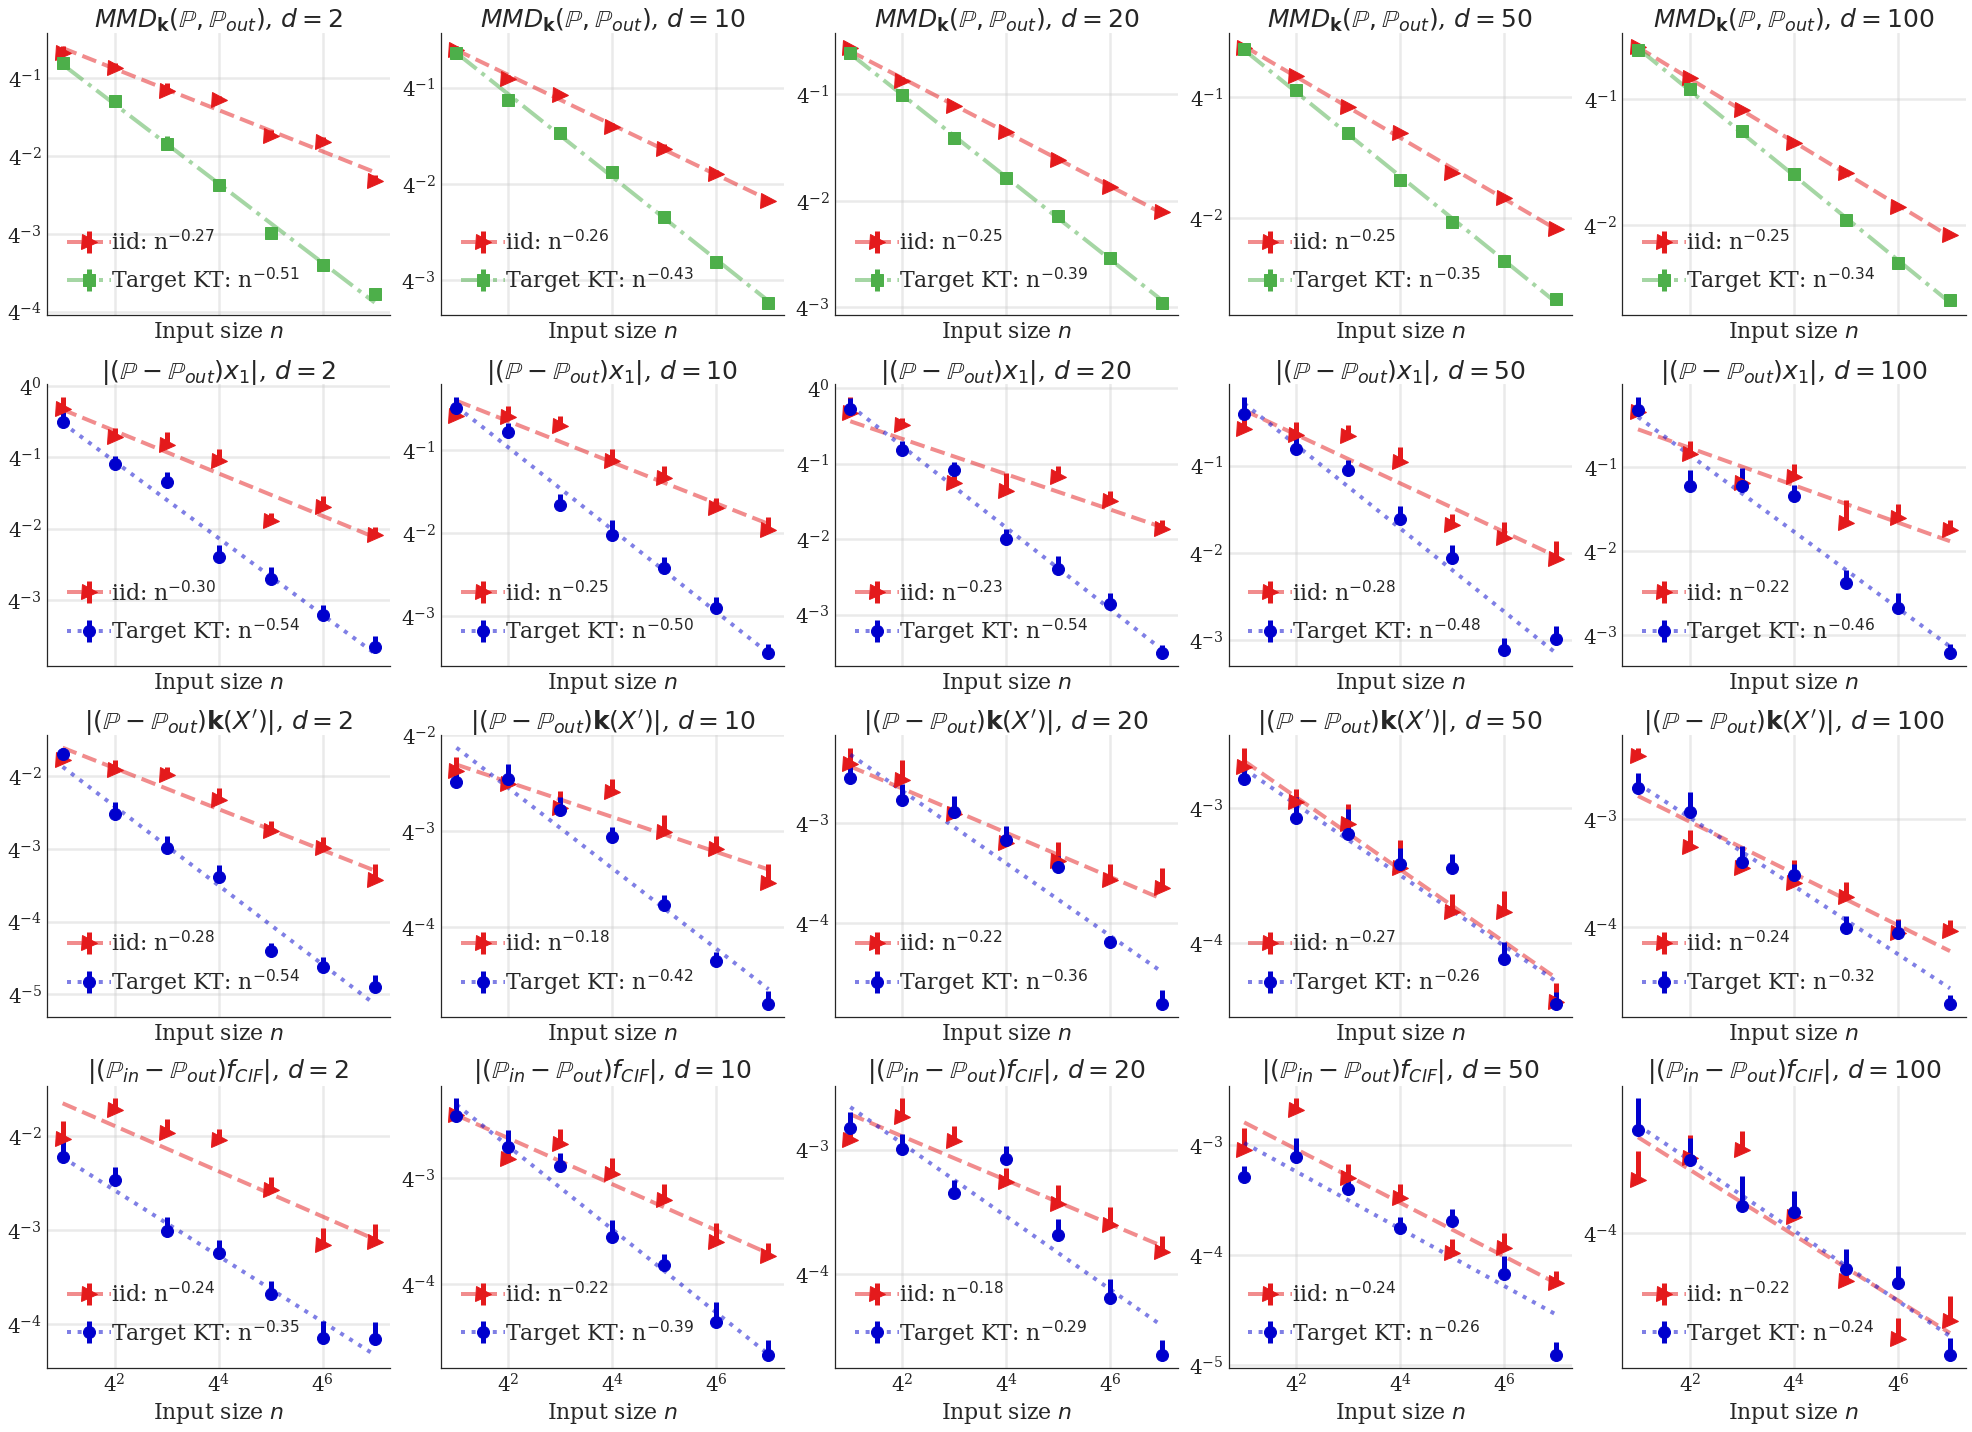

In [73]:
save_fig = False
if run_gauss_experiments:
    for summary in [np.mean]:
        ylab = 'Mean Error' if summary == np.mean else 'Median Error'
        loc = 'lower left'
        leg_size = 18
        skip_ns = int(1)

        a = int(4)
        b = int(len(ds))
        lss = ['--',  '-.',  ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>',  's', 'o',  'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        for i in range(len(ms_size)):
            ms_size[i] *= ms_factor
        colors = ['#e41a1c', '#4daf4a', '#0000cd',  'black' , 'magenta']

        axes = plt.subplots(a, b, figsize=[5.5*b, 5*a], sharex=True, sharey=False)
        
        axes = axes[1] #.flatten() if a!=1 else axes[1] 
        for i, d in enumerate(ds):
            ax = axes[0][i]
            plot_mmd_dict(ax, ms, mmd_results[f"gauss-{d}"]["mmd_p"], 0.5, skip_ns=skip_ns, 
                          error_bar=True, legend_size=22, summary=summary,
                         legend_loc=loc, rm_keys=['KT-best'])
            ax.set_title('%s, $d=%d$'%(mmd_labels[0], d), fontsize=title_size)
            ax.set_xlabel(x_lab, fontsize=xlab_size)
        
        
        lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        for i in range(len(ms_size)):
            ms_size[i] *= ms_factor
        colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']
        
        for jj, (f, k, lab) in enumerate(zip(fun_strs, fun_diff_key, fun_y_labels)):
            
            for i, d in enumerate(ds):
                ax = axes[jj+1][i]
                plot_mmd_dict(ax, ms, fun_results[f"gauss-{d}"][f][k], 0.5, skip_ns=skip_ns, 
                              error_bar=True, legend_size=22, summary=summary,
                             legend_loc=loc, rm_keys=['KT-split', 'KT-best'])
                ax.set_title('%s, $d=%d$'%(lab, d), fontsize=title_size)
    
                ax.set_xlabel(x_lab, fontsize=xlab_size)
        plt.tight_layout()
        if save_fig:
            plt.savefig(fig_dir+f"gauss_d_{min(ds)}_{max(ds)}_{len(ds)}_dcol.pdf")
        plt.show()
                
        
        
        

# 2. MCMC

In [31]:
all_mcmc_filenames = np.array([
    'Goodwin_RW_float_step', 'Goodwin_ADA-RW_float_step',  
    'Goodwin_MALA_float_step',  'Goodwin_PRECOND-MALA_float_step', 
    'Lotka_RW_float_step',  'Lotka_ADA-RW_float_step',  'Lotka_MALA_float_step',
 'Lotka_PRECOND-MALA_float_step',
    'Hinch_P_seed_1_temp_1_scaled', 'Hinch_P_seed_2_temp_1_scaled', 
    'Hinch_TP_seed_1_temp_8_scaled', 'Hinch_TP_seed_2_temp_8_scaled', 
])

## 2.1 Goodwin and Lotka (loading results)

In [34]:
run_goodwin_lotka_experiments = True


In [35]:
parser = init_parser()
args, opt = parser.parse_known_args()
args = convert_arg_flags(args)

In [36]:
generic_prefixes = ["-combinedmmd-"]
keys = ["mmd_sin"]

fun_strs =  ['x',  'x^2', 'kernel', 'cif',]

args.rerun = False
# args.kernel, args.power = "imq", 0.5
args.kernel, args.power = "laplace", 0.81


args.P = "mcmc"
args.rep0 = 0
args.repn = 10
args.m = 7+1         

args.computepower = True
args.targetkt = False
args.powerkt = False
args.ktplus = True

args.stdthin = True

ms = range(args.m)
file_idx = range(0, 8)

In [46]:
if run_goodwin_lotka_experiments:

    for filename in all_mcmc_filenames[file_idx]:
        args.filename = filename
        d, params_p, var_k =  compute_params_p(args)
        args.d = d 
        params_k, params_k_power = compute_params_k(args, var_k, args.computepower, args.power)

        if args.ktplus:
            assert(args.power is not None)
            params_k_combo = dict()
            params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
            params_k_combo["k"] = params_k.copy()
            params_k_combo["kpower"] = params_k_power.copy()
            params_k_combo["var"] = params_k["var"]
            params_k_combo["d"] = args.d
        
        print(f"loading results for {args.kernel} kernel and {args.filename} P in d={d} till m ={args.m}")
        mmd_results[f"{args.P}-{args.filename}"] = load_combined_results(args, keys, generic_prefixes)
        fun_results[f"{args.P}-{args.filename}"] = load_function_approx_results(args, 
                                 fun_strs = fun_strs)

loading results for laplace kernel and Goodwin_RW_float_step P in d=4 till m =8
results_new/combined/mc-combinedmmd--Goodwin_RW_float_step_endpt_nmax_15--split_laplace_var0.0004_seed9876543-swap_laplace_var0.0004-d4-m7-delta0.5-rep10.pkl
loading results for laplace kernel and Goodwin_ADA-RW_float_step P in d=4 till m =8
results_new/combined/mc-combinedmmd--Goodwin_ADA-RW_float_step_endpt_nmax_15--split_laplace_var0.00040401_seed9876543-swap_laplace_var0.00040401-d4-m7-delta0.5-rep10.pkl
loading results for laplace kernel and Goodwin_MALA_float_step P in d=4 till m =8
results_new/combined/mc-combinedmmd--Goodwin_MALA_float_step_endpt_nmax_15--split_laplace_var0.00029241_seed9876543-swap_laplace_var0.00029241-d4-m7-delta0.5-rep10.pkl
loading results for laplace kernel and Goodwin_PRECOND-MALA_float_step P in d=4 till m =8
results_new/combined/mc-combinedmmd--Goodwin_PRECOND-MALA_float_step_endpt_nmax_15--split_laplace_var0.00042025000000000005_seed9876543-swap_laplace_var0.00042025000000

## 2.2 Hinch (Loading results)

In [47]:
run_hinch_experiments = True

parser = init_parser()
args, opt = parser.parse_known_args()
args = convert_arg_flags(args)

In [50]:
generic_prefixes = ["-combinedmmd-"]
keys = ["mmd_sin"]

fun_strs =  ['x',  'x^2', 'kernel', 'cif',]


args.rerun = False
# args.kernel, args.power = "laplace", 0.9872
args.kernel, args.power = "imq", 0.5
args.P = "mcmc"
args.rep0 = 0
args.repn = 10
args.m = 7+1         


args.computepower = True
args.targetkt = False
args.powerkt = False
args.ktplus = True

args.stdthin = True
ms = range(args.m)

file_idx = range(8, 12)


In [51]:
if run_hinch_experiments:

    for filename in all_mcmc_filenames[file_idx]:
        args.filename = filename
        d, params_p, var_k =  compute_params_p(args)
        args.d = d 
        params_k, params_k_power = compute_params_k(args, var_k, args.computepower, args.power)

        if args.ktplus:
            assert(args.power is not None)
            params_k_combo = dict()
            params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
            params_k_combo["k"] = params_k.copy()
            params_k_combo["kpower"] = params_k_power.copy()
            params_k_combo["var"] = params_k["var"]
            params_k_combo["d"] = args.d
        
        print(f"loading results for {args.kernel} kernel and {args.filename} P in d={d} till m ={args.m}")
        mmd_results[f"{args.P}-{args.filename}"] = load_combined_results(args, keys, generic_prefixes)
        fun_results[f"{args.P}-{args.filename}"] = load_function_approx_results(args, 
                                 fun_strs = fun_strs)

loading results for imq kernel and Hinch_P_seed_1_temp_1_scaled P in d=38 till m =8
results_new/combined/mc-combinedmmd--Hinch_P_seed_1_temp_1_scaled_endpt_nmax_15--split_imq_var65.08616976_seed9876543_nu0.5-swap_imq_var65.08616976_nu0.5-d38-m7-delta0.5-rep10.pkl
loading results for imq kernel and Hinch_P_seed_2_temp_1_scaled P in d=38 till m =8
results_new/combined/mc-combinedmmd--Hinch_P_seed_2_temp_1_scaled_endpt_nmax_15--split_imq_var69.20409720999999_seed9876543_nu0.5-swap_imq_var69.20409720999999_nu0.5-d38-m7-delta0.5-rep10.pkl
loading results for imq kernel and Hinch_TP_seed_1_temp_8_scaled P in d=38 till m =8
results_new/combined/mc-combinedmmd--Hinch_TP_seed_1_temp_8_scaled_endpt_nmax_15--split_imq_var74.32164100000001_seed9876543_nu0.5-swap_imq_var74.32164100000001_nu0.5-d38-m7-delta0.5-rep10.pkl
loading results for imq kernel and Hinch_TP_seed_2_temp_8_scaled P in d=38 till m =8
results_new/combined/mc-combinedmmd--Hinch_TP_seed_2_temp_8_scaled_endpt_nmax_15--split_imq_var75

## 2.3 Visualize the  combined results

In [52]:
def mcmc_titles(a):
    # function to reformat titles for figures corresponding to Hinch data with filename starting with a
    a = a.replace("_P_", " ")
    a = a.replace("_TP_", " Tempered ")
    a = a.replace("seed_1", "")
    a = a.replace("seed_2", "2")
    a = a.replace("_temp_1", "")
    a = a.replace("_temp_8", "")
    a = a.replace("_scaled", "")
    a = a.replace("_float_step", "")
    a = a.replace("_", " ")
    a = a.replace("PRECOND-", "p")
#     a += ")"
    return(a)



In [53]:
mmd_labels = ["$MMD_{\\bf k}(\\mathbb{P}_{in}, \\mathcal{S}_{out})$"]
mmd_labels = ["$MMD_{\\bf k}(\\mathcal{S}_{in}, \\mathcal{S}_{out})$"]
mmd_labels = ["$MMD_{\\bf k}(\\mathbb{P}_{in}, \\mathbb{P}_{out})$"]


fun_latex = ['x_1', 'x_1^2', "\mathbf{k}(X')", 'f_{CIF}'] 
fun_diff_key = ['fundiff_sin',  'fundiff_sin', 'fundiff_sin', 'fundiff_sin']

fun_y_labels = [] 

for f, k, latex in zip(fun_strs, fun_diff_key, fun_latex):
    if 'p' in k:
        fun_y_labels.append(r"$|(\mathbb{P} - \mathbb{P}_{out})  %s|$"% latex)
    else:
        fun_y_labels.append(r"$|(\mathbb{P}_{in} - \mathbb{P}_{out})  %s|$"% latex)

In [54]:
ylab_size = 27
xlab_size = 22
title_size = 25
leg_size = 22
ms_factor = 1.2

In [55]:
mf1 = ['Goodwin_ADA-RW_float_step',  'Lotka_ADA-RW_float_step', 'Hinch_P_seed_1_temp_1_scaled']
mf2 = ['Goodwin_RW_float_step',  'Lotka_RW_float_step', 'Hinch_P_seed_2_temp_1_scaled']
mf3 = ['Goodwin_MALA_float_step',  'Lotka_MALA_float_step', 'Hinch_TP_seed_1_temp_8_scaled']
mf4 = ['Goodwin_PRECOND-MALA_float_step',  'Lotka_PRECOND-MALA_float_step', 'Hinch_TP_seed_2_temp_8_scaled']

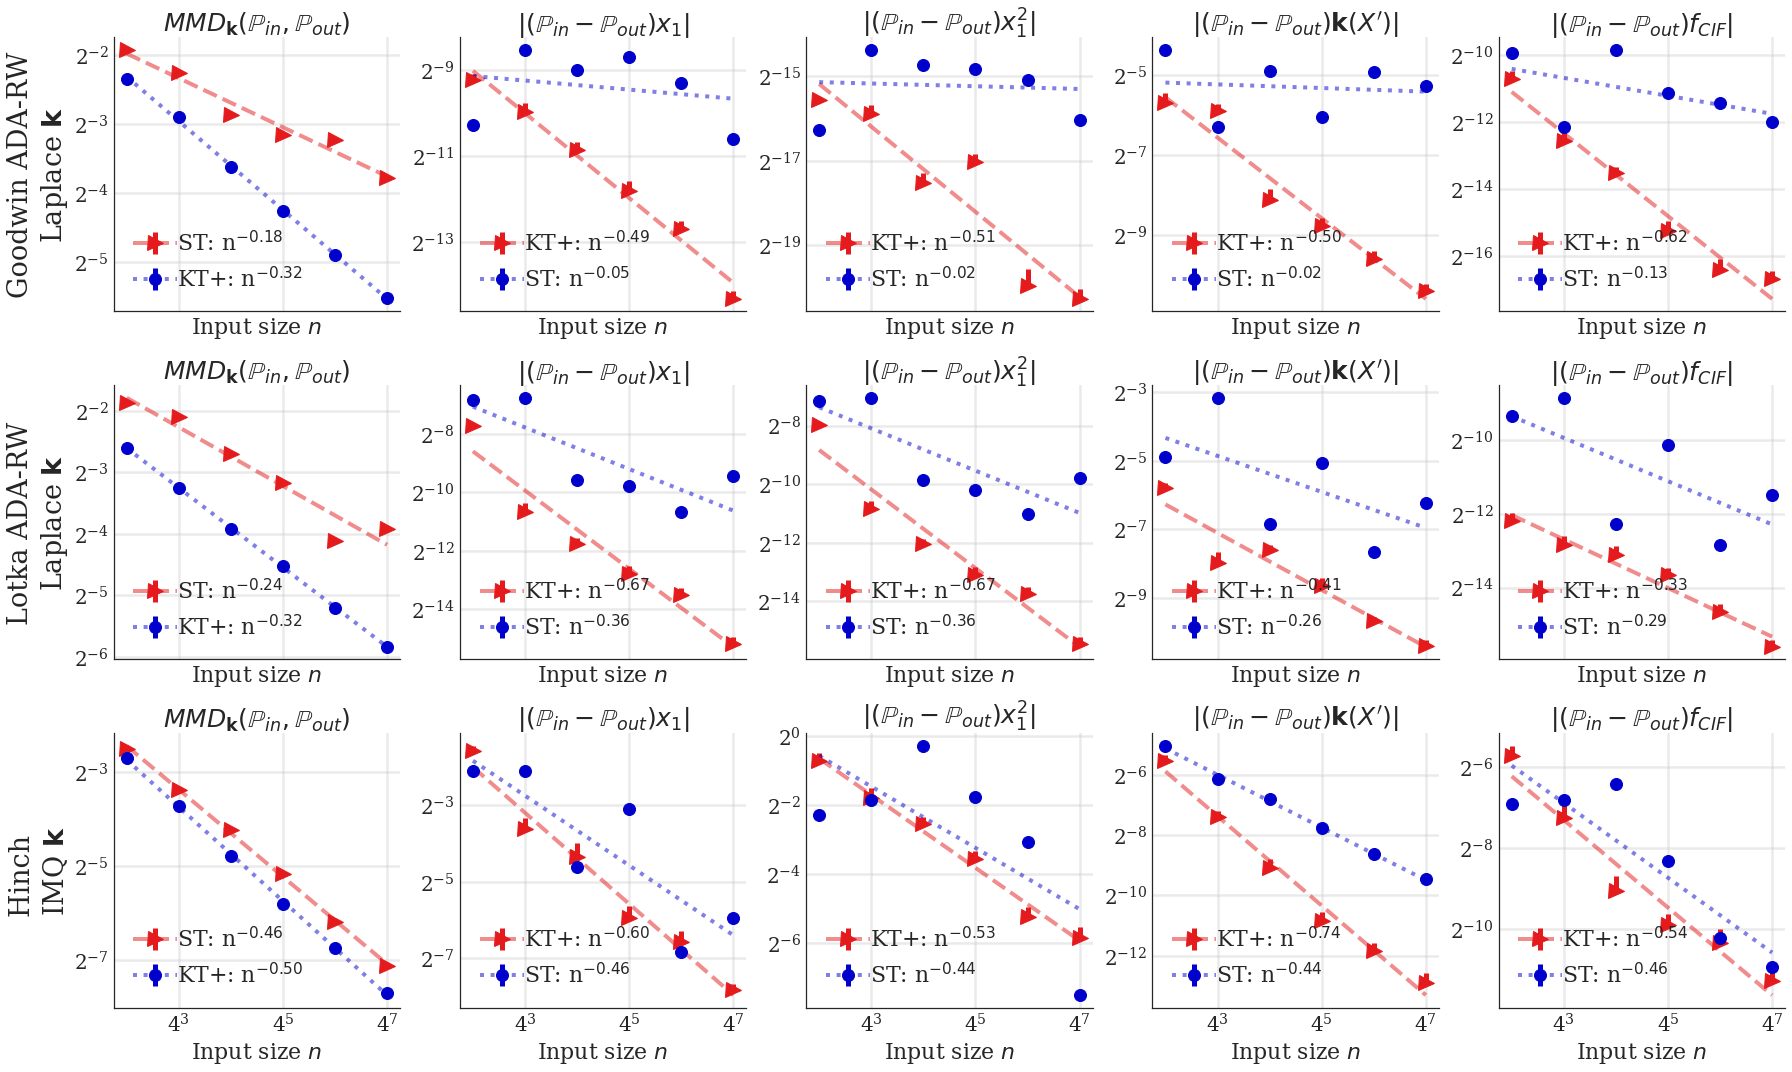

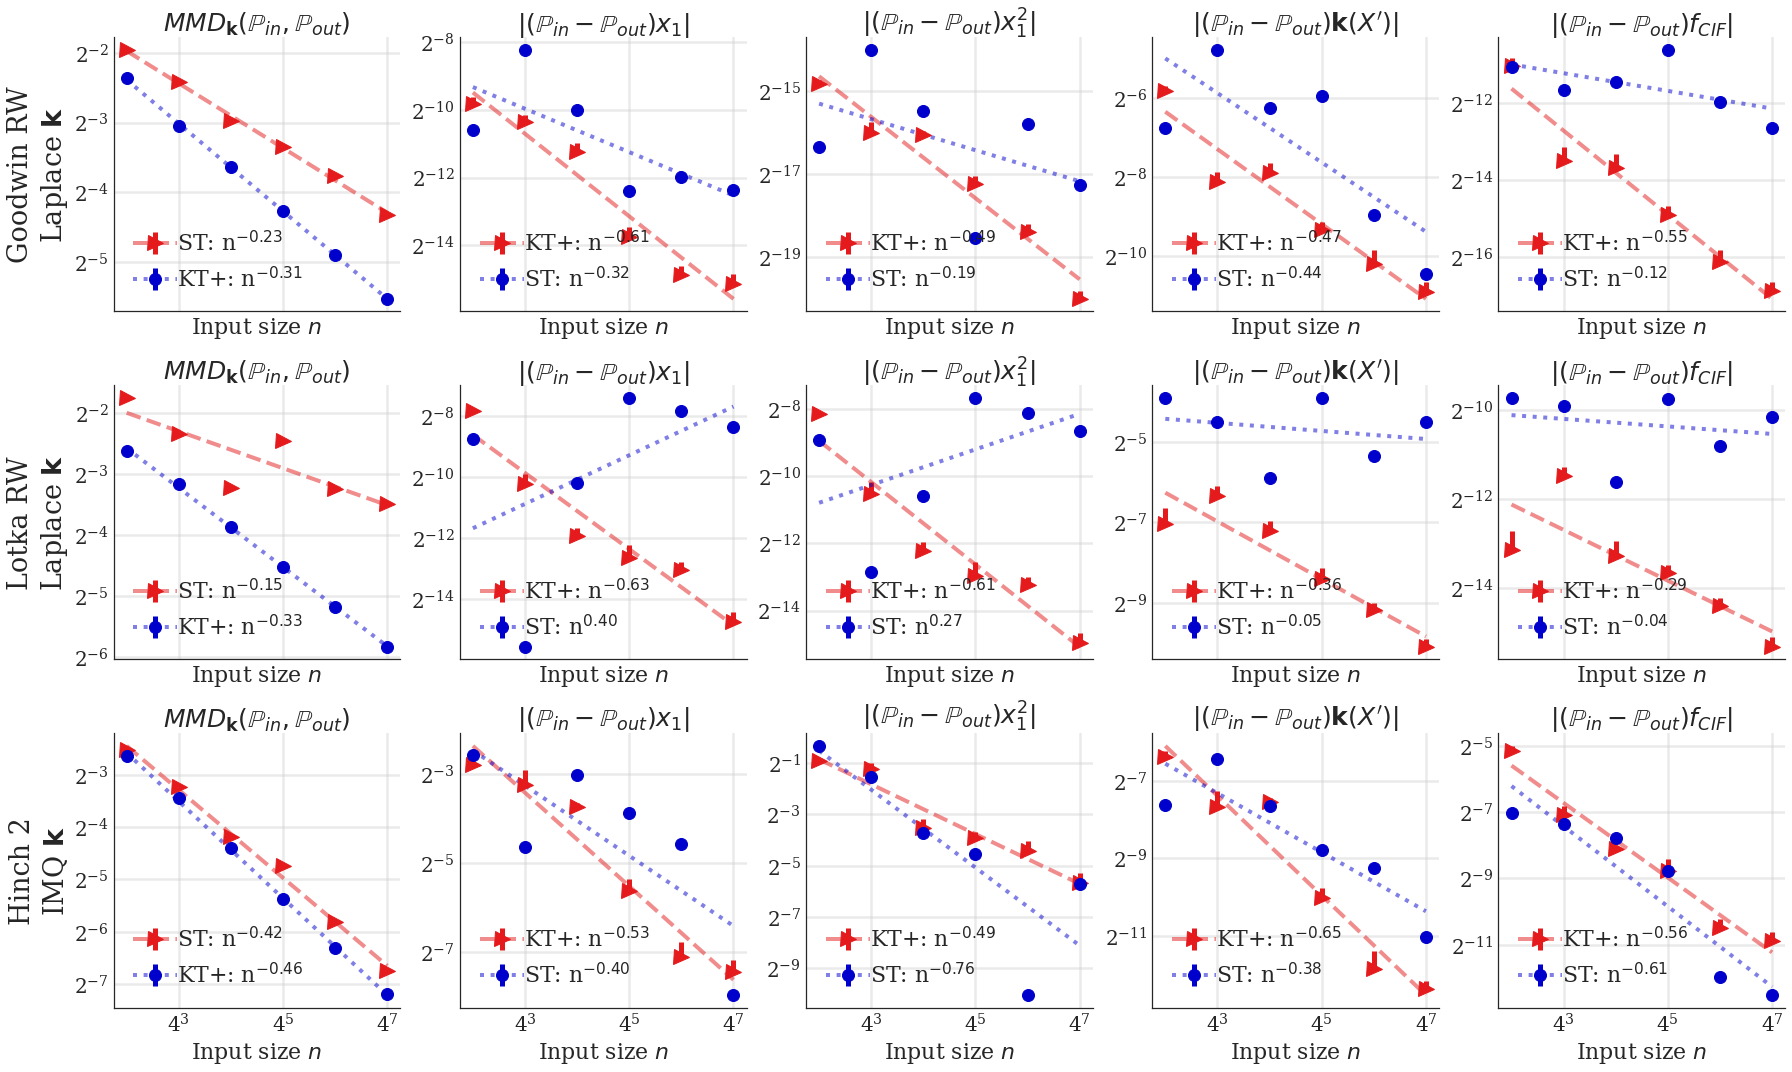

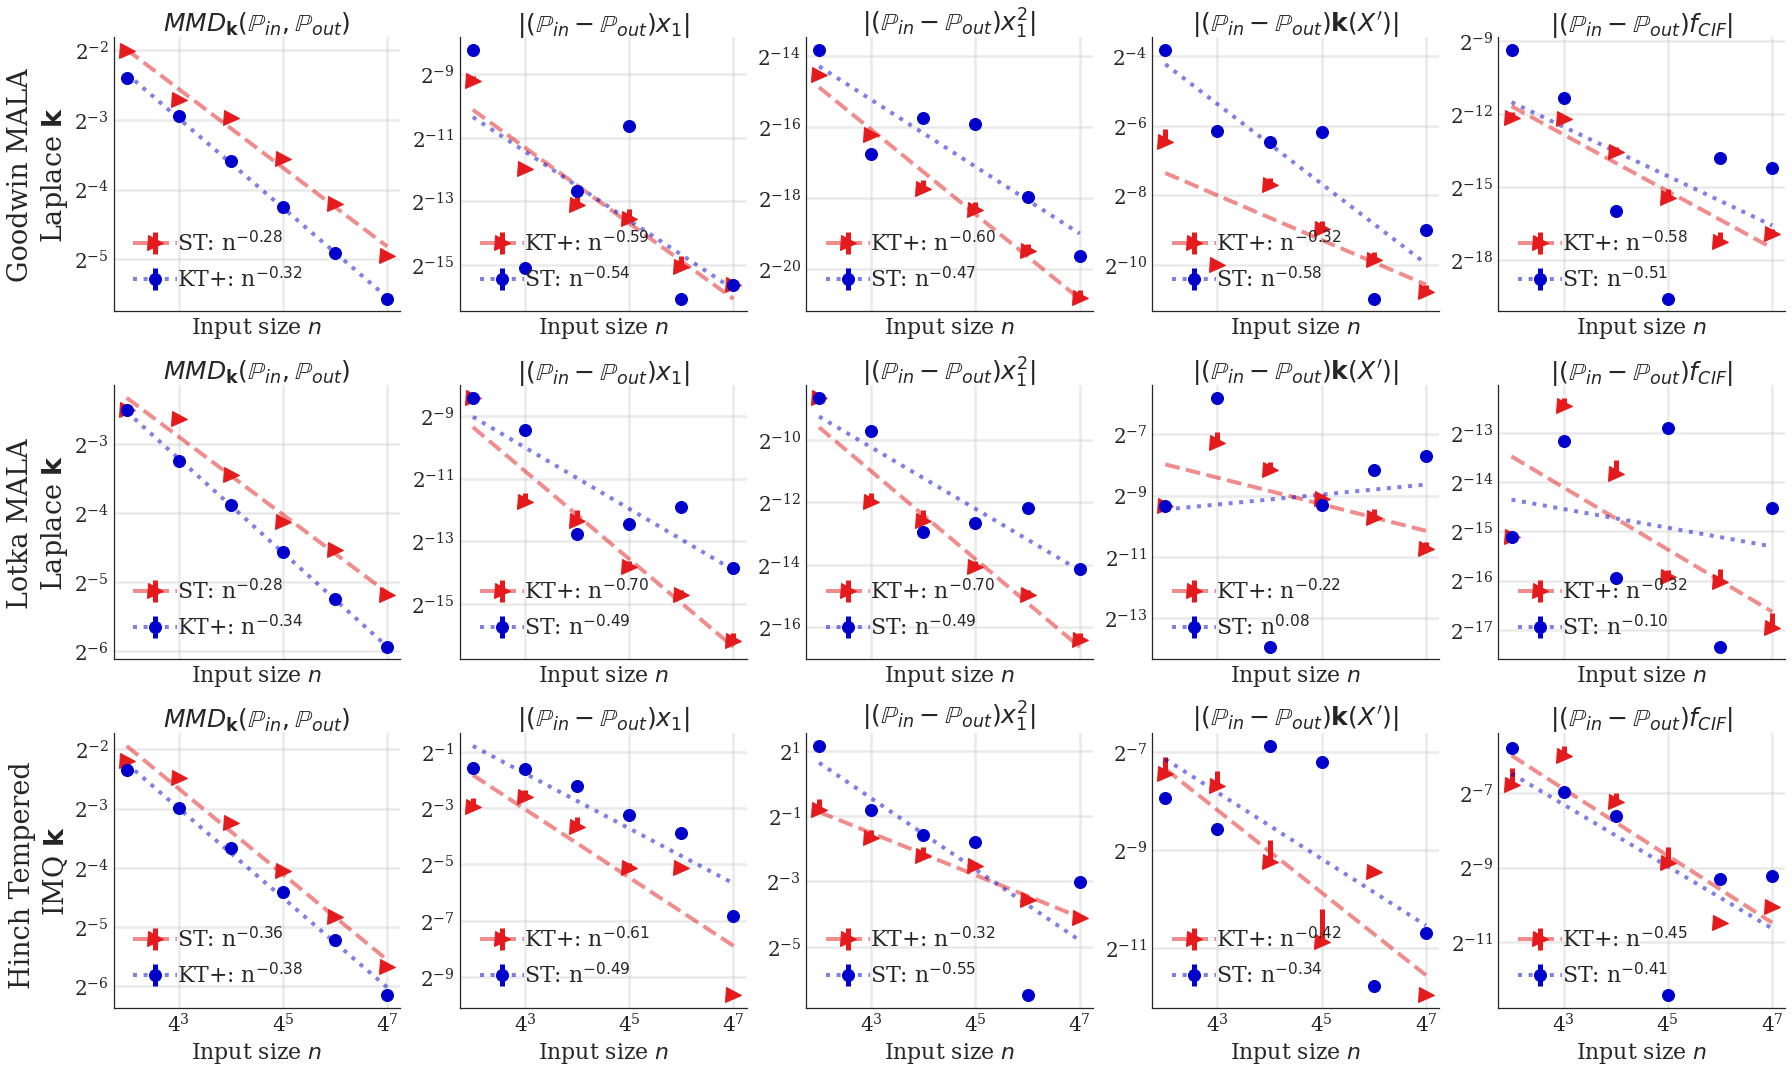

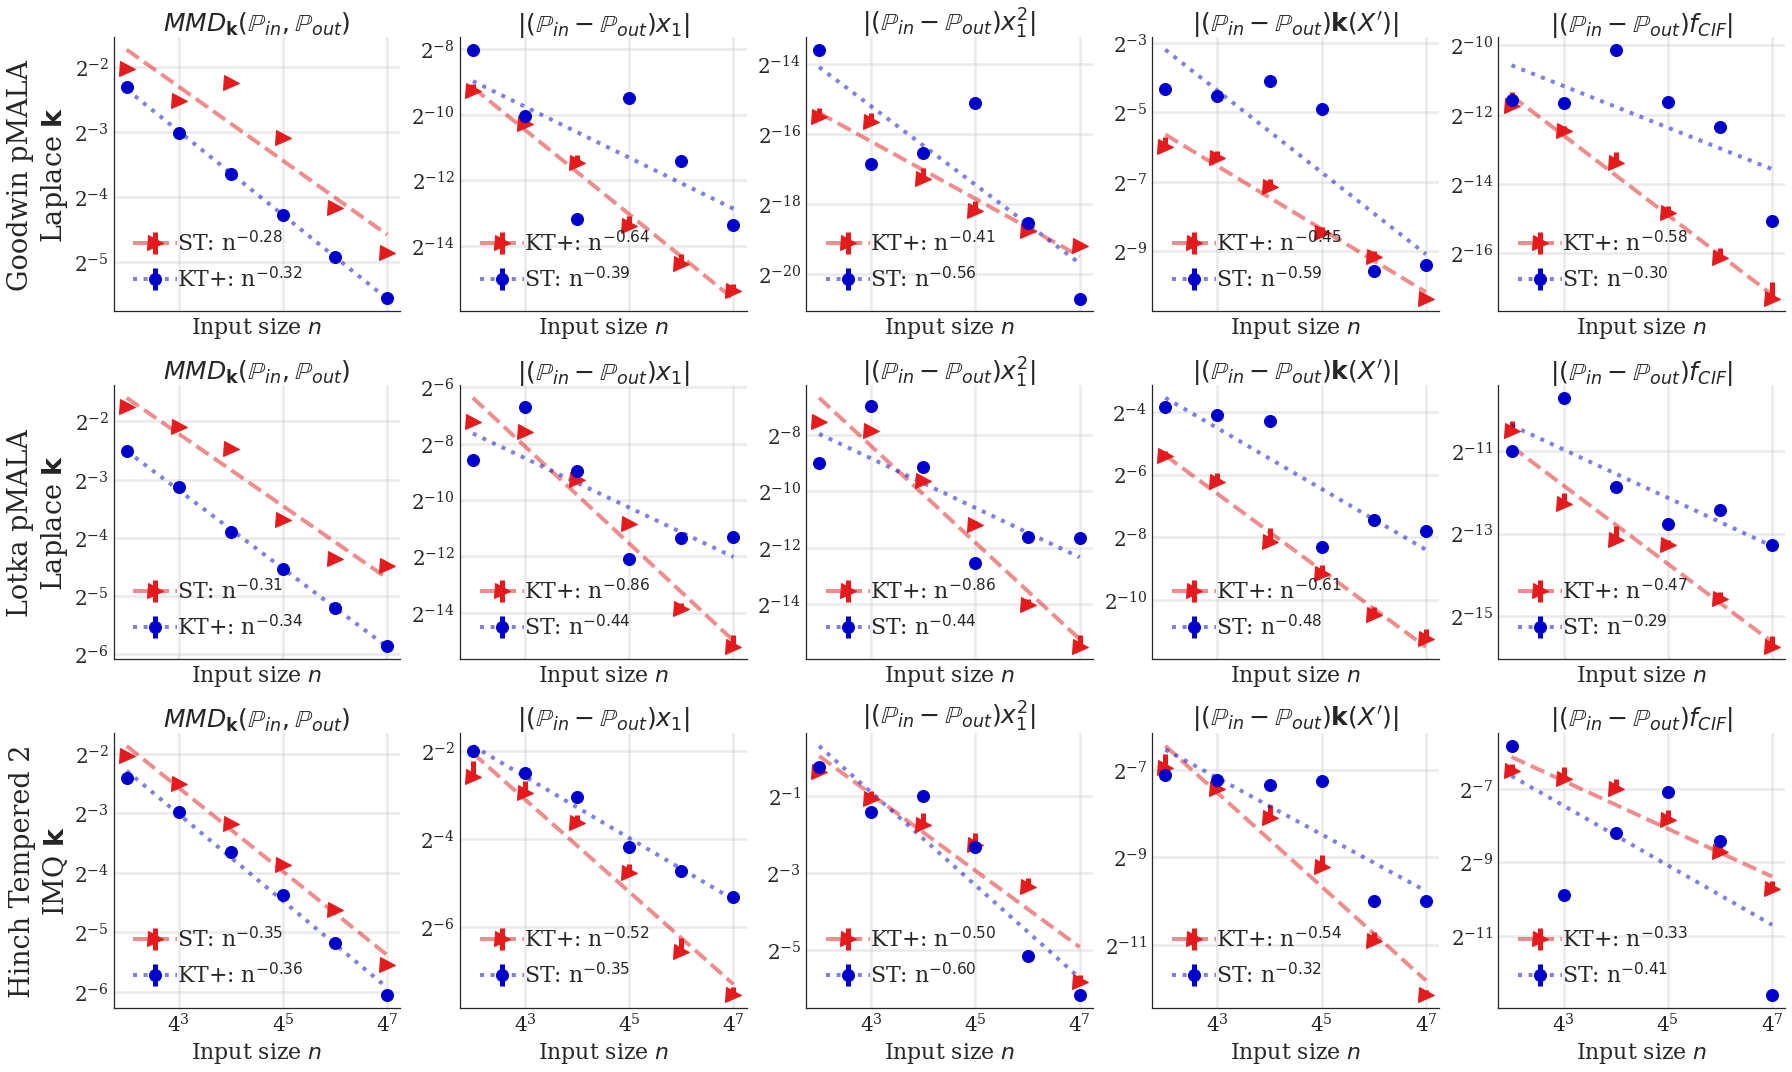

In [56]:
save_fig = False

plot_keys = ['standard', 'KT+'] # None
standard_label = "ST"

mf_list = [mf1, mf2, mf3, mf4]
k_list = ["Laplace", "Laplace", "IMQ" ]
for ss, plot_filenames in enumerate(mf_list):

    for summary in [np.mean]:
        ylab = 'Mean Error' if summary == np.mean else 'Median Error'
        loc = 'lower left'
        
        skip_ns = int(2)


        a = int(len(plot_filenames))  # number of rows
        b = int(len(fun_strs)+1) # number of columns
        axes = plt.subplots(a, b, figsize=[5*b, 5*a], sharex=True, sharey=False)
        
        lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']
        for i in range(len(ms_size)):
            ms_size[i] *= ms_factor

        axes = axes[1] #.flatten() if a!=1 else axes[1] 
        for i, fname in enumerate(plot_filenames):
            ax = axes[i][0]
            plot_mmd_dict(ax, ms, mmd_results[f"mcmc-{fname}"]["mmd_sin"], 0.5, skip_ns=skip_ns, 
                          error_bar=True, legend_size=leg_size, summary=summary,
                         legend_loc=loc, basey=2, plot_keys=plot_keys, standard_label=standard_label)
            ax.set_title('%s'%(mmd_labels[0]), fontsize=title_size)
            ax.set_xlabel(x_lab, fontsize=xlab_size)
            ax.set_ylabel(mcmc_titles(fname) + '\n%s ${\\bf k}$'%k_list[i], fontsize=ylab_size)


        lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        for i in range(len(ms_size)):
            ms_size[i] *= ms_factor
            
        colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']

        for jj, (f, k, lab) in enumerate(zip(fun_strs, fun_diff_key, fun_y_labels)):
            # axes = plt.subplots(a, b, figsize=[5*b, 5*a], sharex=True, sharey=True)
            # axes = axes[jj+1][].flatten() if a!=1 else axes[1] 
            for i, fname in enumerate(plot_filenames):
                ax = axes[i][jj+1]
                plot_mmd_dict(ax, ms, fun_results[f"mcmc-{fname}"][f][k], 0.5, skip_ns=skip_ns, 
                              error_bar=True, legend_size=leg_size, summary=summary,
                             legend_loc=loc, basey=2,  plot_keys=plot_keys, standard_label=standard_label)
                ax.set_title('%s'%(lab), fontsize=title_size)
    #                 if i==0:
    #                     ax.set_ylabel(lab, fontsize=ylab_size)
                ax.set_xlabel(x_lab, fontsize=xlab_size)
        plt.tight_layout()
        if save_fig:
            plt.savefig(fig_dir+f"mcmc_{ss}_{standard_label}.pdf")
        plt.show()





## MCMC 5 by 6 plots

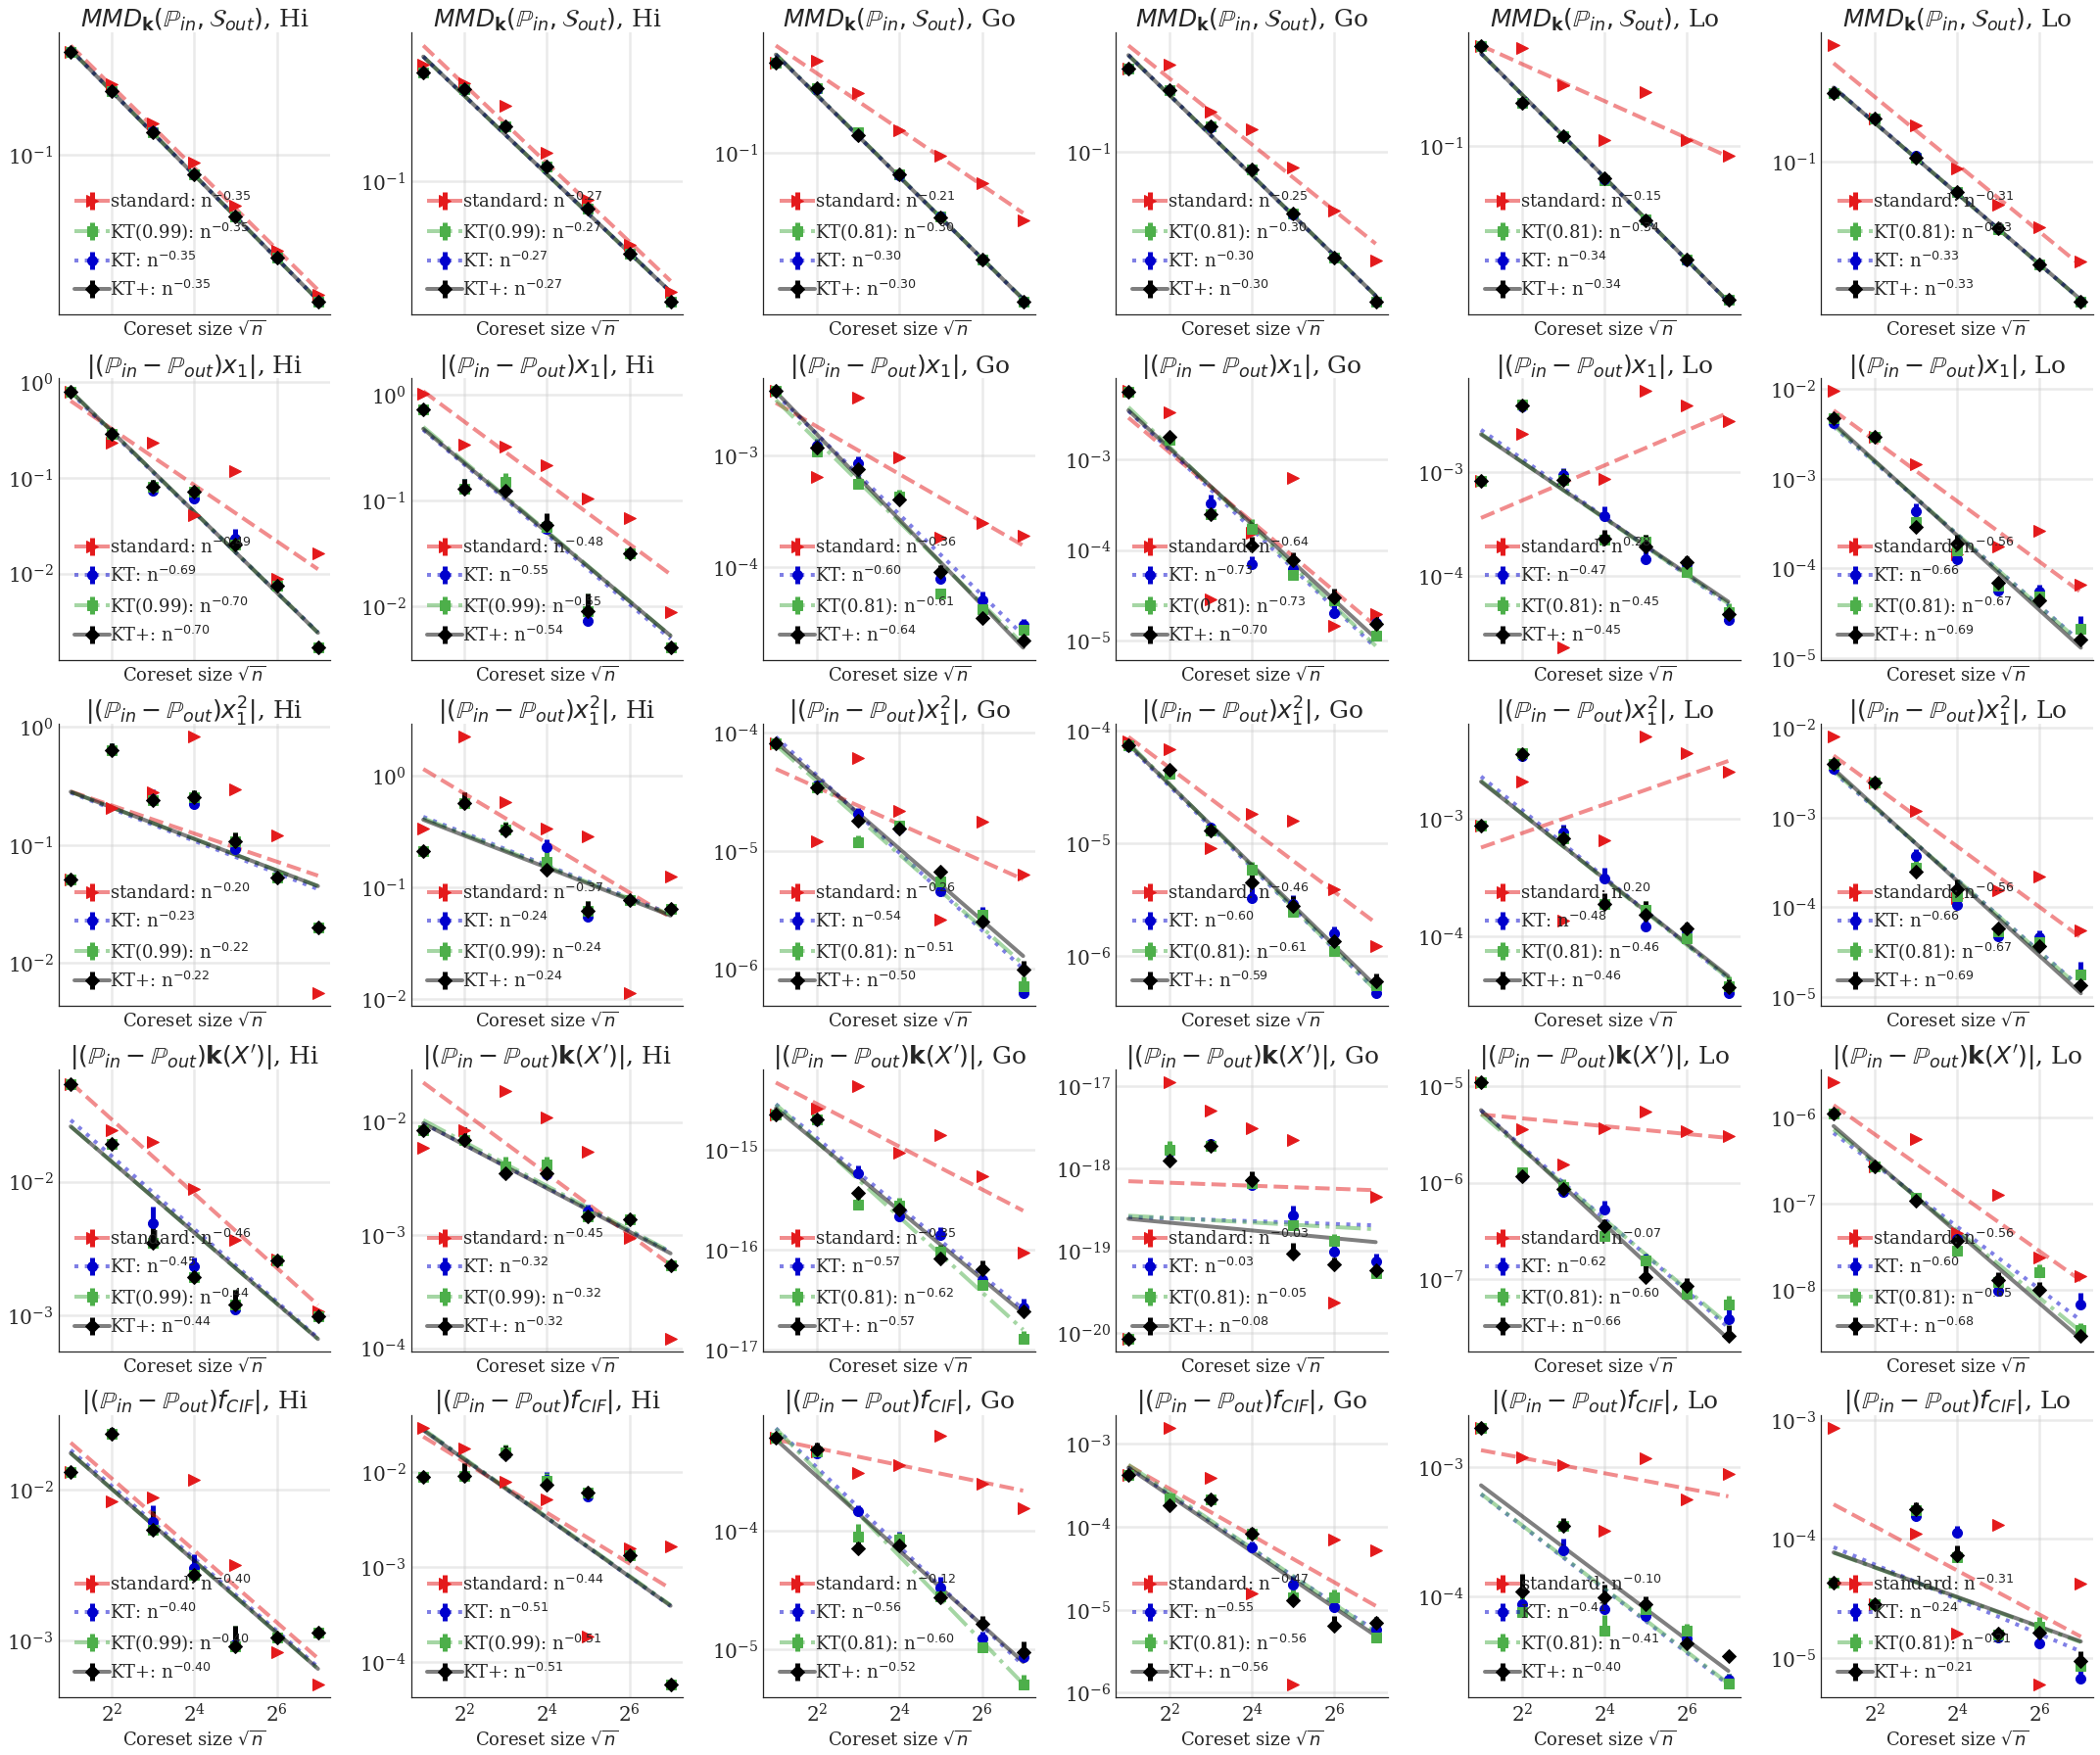

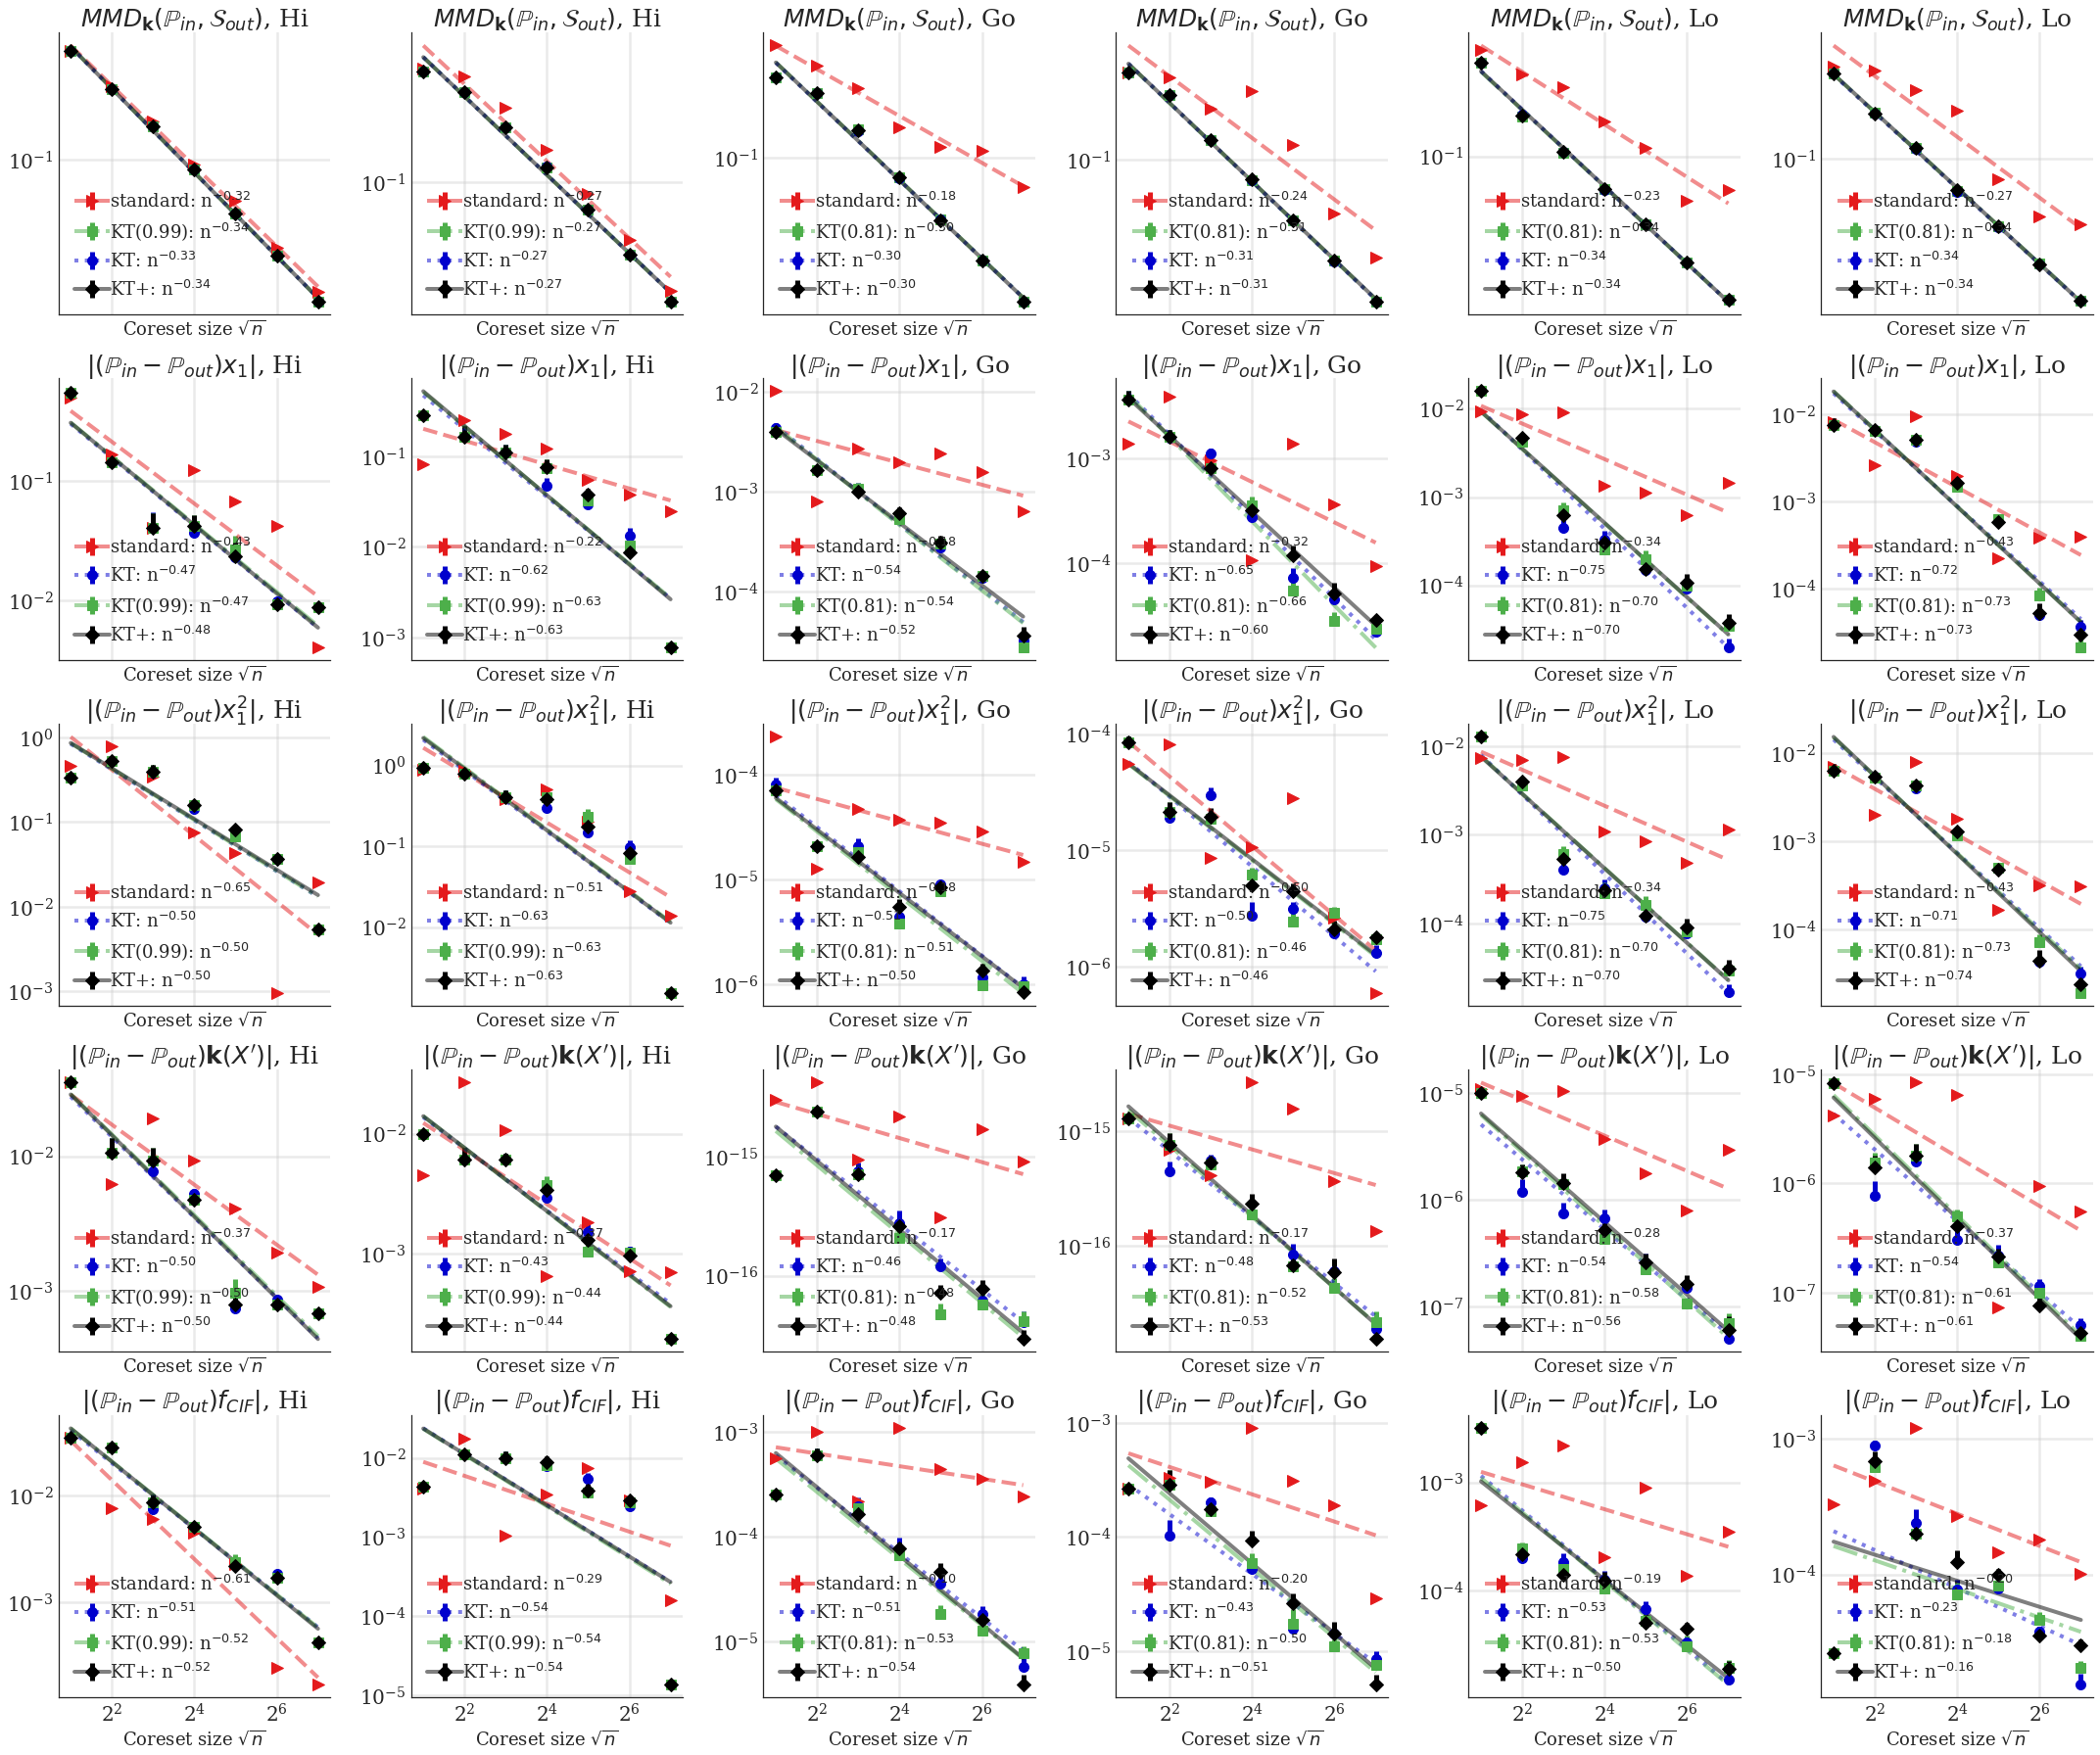

In [46]:
save_fig = False
for plot_filenames in [all_mcmc_filenames[::2], all_mcmc_filenames[1::2]]:

    for summary in [np.mean]:
        ylab = 'Mean Error' if summary == np.mean else 'Median Error'
        loc = 'lower left'
        leg_size = 18
        skip_ns = int(1)

        a = int(len(fun_strs)+1)
        b = int(len(plot_filenames))
        lss = ['--',  '-.',  ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>',  's', 'o',  'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        colors = ['#e41a1c', '#4daf4a', '#0000cd',  'black' , 'magenta']

        axes = plt.subplots(a, b, figsize=[5*b, 5*a], sharex=True, sharey=False)

        axes = axes[1] #.flatten() if a!=1 else axes[1] 
        for i, fname in enumerate(plot_filenames):
            ax = axes[0][i]
            plot_mmd_dict(ax, ms, mmd_results[f"mcmc-{fname}"]["mmd_sin"], 0.5, skip_ns=skip_ns, 
                          error_bar=True, legend_size=leg_size, summary=summary,
                         legend_loc=loc, basey=10)
            ax.set_title('%s, %s'%(mmd_labels[0], fname[:2]), fontsize=title_size)
            ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)


        lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        colors = ['#e41a1c', '#0000cd', '#4daf4a',  'black' , 'magenta']

        for jj, (f, k, lab) in enumerate(zip(fun_strs, fun_diff_key, fun_y_labels)):
            # axes = plt.subplots(a, b, figsize=[5*b, 5*a], sharex=True, sharey=True)
            # axes = axes[jj+1][].flatten() if a!=1 else axes[1] 
            for i, fname in enumerate(plot_filenames):
                ax = axes[jj+1][i]
                plot_mmd_dict(ax, ms, fun_results[f"mcmc-{fname}"][f][k], 0.5, skip_ns=skip_ns, 
                              error_bar=True, legend_size=leg_size, summary=summary,
                             legend_loc=loc, basey=10)
                ax.set_title('%s, %s'%(lab, fname[:2]), fontsize=title_size)
    #                 if i==0:
    #                     ax.set_ylabel(lab, fontsize=ylab_size)
                ax.set_xlabel("Coreset size $\sqrt{n}$", fontsize=xlab_size)
        plt.tight_layout()
    #         if save_fig:
    #             plt.savefig(fig_dir+f"mcmc_d_{min(ds)}_{max(ds)}_{len(ds)}_dcol.pdf")
        plt.show()





## MOG coreset visualizations

In [98]:
rep_id = 2
d = 2
var =  float(2*d)
params_p = compute_diag_mog_params(M)
Xs = dict()
m_plots = np.arange(3, 5, dtype=int )
for m in m_plots:
    Xs[m] = dict()
    params_k = {"name": "gauss", "var": var, "d": int(d)}
    params_k_power = {"name": "gauss_rt", "var": var/2., "d": int(d)}
    
    Xs[m]["i.i.d."], Xs[m]["Root KT (Gauss)"] = load_input_and_coreset(m, params_p, params_k_power, params_k, rep_id)
    _, Xs[m]["Target KT (Gauss)"] = load_input_and_coreset(m, params_p, params_k, params_k, rep_id)
    
    


    args.power = 0.5
    params_k = {"name": "imq", "nu": 0.5, "var":var, "d": int(d)}
    params_k_power = {"name": "imq_rt", "nu": 0.75, "var":var, "d": int(d)}
    params_k_combo = dict()
    params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
    params_k_combo["k"] = params_k.copy()
    params_k_combo["kpower"] = params_k_power.copy()
    params_k_combo["var"] = params_k["var"]
    params_k_combo["d"] = d
#     _, Xs[m]["KT (IMQ)"] = load_input_and_coreset(m, params_p, params_k, params_k, rep_id)
#     _, Xs[m]["KT(rt) (IMQ)"] = load_input_and_coreset(m, params_p, params_k_power, params_k, rep_id)
    _, Xs[m]["KT+ (IMQ)"] = load_input_and_coreset(m, params_p, params_k_combo, params_k, rep_id, thin_str="-plus")

    args.power = 0.70
    params_k = {"name": "laplace", "nu": 0.5, "var":var, "d": int(d)}
    params_k_power = {"name": f"laplace{args.power}_rt", "nu": args.power * (d+1)/2., "var":var, "d": int(d)}
    params_k_combo = dict()
    params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
    params_k_combo["k"] = params_k.copy()
    params_k_combo["kpower"] = params_k_power.copy()
    params_k_combo["var"] = params_k["var"]
    params_k_combo["d"] = d
#     _, Xs[m]["KT (Laplace)"] = load_input_and_coreset(m, params_p, params_k, params_k, rep_id)
#     _, Xs[m]["KT(rt) (Laplace)"] = load_input_and_coreset(m, params_p, params_k_power, params_k, rep_id)
    _, Xs[m]["KT+ (Laplace)"] = load_input_and_coreset(m, params_p, params_k_combo, params_k, rep_id, thin_str="-plus")

    args.power = 2/3.
    params_k = {"name": "bspline", "nu": 2., "var":var, "d": int(d)}
    params_k_power = {"name": f"bspline{args.power}_rt", "nu": args.power * 2., "var":var, "d": int(d)}
    params_k_combo = dict()
    params_k_combo["name"] = "combo_"  + params_k["name"] + f"_{args.power}"
    params_k_combo["k"] = params_k.copy()
    params_k_combo["kpower"] = params_k_power.copy()
    params_k_combo["var"] = params_k["var"]
    params_k_combo["d"] = d
    _, Xs[m]["KT+ (Bspline)"] = load_input_and_coreset(m, params_p, params_k_combo, params_k, rep_id, thin_str="-plus")
    

In [99]:
colors = ['#e41a1c', '#4daf4a', '#0000cd',  'black' , 'magenta', 'orange']

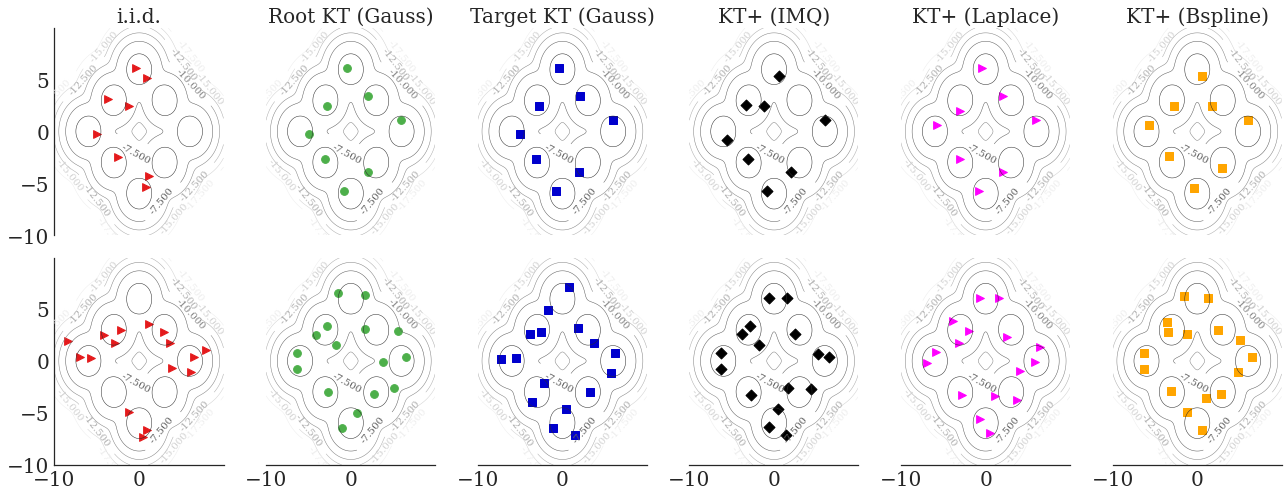

In [100]:
save_fig = True
sample_seed = 1234567
contour = True
# use contour (True) lines or filled contour plot (False)

for M in [8]:
    params_p = compute_diag_mog_params(M)
    snr = 2*max(params_p["covs"])
    if M == 4:
        snr *= 2.5
    else:
        snr *= 2
    lim0 = np.min(params_p["means"])-snr
    lim1 = np.max(params_p["means"])+snr
    x, y = np.mgrid[lim0:lim1:.05, lim0:lim1:.05]
    pos = np.dstack((x, y))
    # compute pdf of the diag MOg density
    for i in range(M):
        rv_object = multivariate_normal(params_p["means"][i], np.eye(d) * params_p["covs"][i])
        if i == 0:
            density = params_p["weights"][i]*rv_object.pdf(pos)
        else:
            density += params_p["weights"][i]*rv_object.pdf(pos)

    a, b = len(m_plots), 6 
    axes = plt.subplots(a, b, figsize=[3*b, 3.5*a], sharex=True, sharey=True)    

    for i, m in enumerate(m_plots): 
        n = int(2**m)
        for j, (label, X) in enumerate(Xs[m].items()):
            ax = axes[1][i][j]
            # plot density of the MoG
            if contour:
                C = ax.contour(x, y, np.log(density+np.exp(-20)), cmap="Greys", linewidths=.5)
                ax.clabel(C, inline=1, fontsize=10)
            else:
                ax.contourf(x, y, np.log(density+np.exp(-20)), cmap="Greys")
            # scatter plot
            if label == "iid":
                # do standard thinning of the iid points
                step = int(X.shape[0]/n)
                ax.scatter(X[step-1:X.shape[0]:step, 0], X[step-1:X.shape[0]:step, 1], marker=mss[j], s=60,  color=colors[j], label=label)
            else:
                #print(j, X)
                ax.scatter(X[:n, 0], X[:n, 1], marker=mss[j], s=60,  color=colors[j], label=label)

            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            if i == 0:
                ax.set_title(f"{label}", fontsize=20)
                ax.spines['bottom'].set_visible(False)
            if j == 0:
                ax.spines['left'].set_visible(True)

#             ax.set_title(f"{n} {label} points", fontsize=10)
#             if j==0:
#                 ax.spines['left'].set_visible(True)
#             if j==len(Xs)-1:
#                 ax.spines['bottom'].set_visible(True)
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(fig_dir+f"mog_8_scatter_{rep_id}.pdf")
    plt.show()

## MOG MMD Rates

In [138]:
Ms = [4, 6, 8]

generic_prefixes = ["-combinedmmd-"]
keys = ["mmd_p"]

args.rerun = False
args.P = "mog"
args.rep0 = 0
args.repn = 10
args.m = 7+1         

args.d = 2
args.computepower = True
args.targetkt = True
args.powerkt = True
args.stdthin = True
args.ktplus = True
ms = range(args.m)


for args.nu, args.kernel, args.power in zip([0.5, 0.5, 0.5, 2.], 
                                  ["imq", "laplace", "gauss", "bspline"], 
                                   [0.5, 0.70, 0.5, 2/3.]):
    
    args.computepower=True
    args.targetkt = True
    args.powerkt = True

#     if args.kernel == "bspline":
#         args.computepower = False
#         args.nu = 2
#         args.ktplus = False
#         args.powerkt = False
#         print("hi")
#     else:
        

    for M in Ms:
        args.M = M
        print(f"loading results for {args.kernel} kernel and {args.P} P for M={M} till m ={args.m}")
        mmd_results[f"{args.P}-{args.kernel}-{args.M}"] = load_combined_results(args, keys, generic_prefixes)


loading results for imq kernel and mog P for M=4 till m =8
results_new/combined/mc-combinedmmd--diag_mog_comp4_seed1234567--split_imq_var4.0_seed9876543_nu0.5-swap_imq_var4.0_nu0.5-d2-m7-delta0.5-rep10.pkl
results_new/combined/kt-combinedmmd--diag_mog_comp4_seed1234567--split_imq_var4.0_seed9876543_nu0.5-swap_imq_var4.0_nu0.5-d2-m7-delta0.5-rep10.pkl
loading results for imq kernel and mog P for M=6 till m =8
results_new/combined/mc-combinedmmd--diag_mog_comp6_seed1234567--split_imq_var4.0_seed9876543_nu0.5-swap_imq_var4.0_nu0.5-d2-m7-delta0.5-rep10.pkl
results_new/combined/kt-combinedmmd--diag_mog_comp6_seed1234567--split_imq_var4.0_seed9876543_nu0.5-swap_imq_var4.0_nu0.5-d2-m7-delta0.5-rep10.pkl
loading results for imq kernel and mog P for M=8 till m =8
results_new/combined/mc-combinedmmd--diag_mog_comp8_seed1234567--split_imq_var4.0_seed9876543_nu0.5-swap_imq_var4.0_nu0.5-d2-m7-delta0.5-rep10.pkl
results_new/combined/kt-combinedmmd--diag_mog_comp8_seed1234567--split_imq_var4.0_seed98

In [139]:
mmd_labels = ["$MMD_{\\bf k}(\\mathbb{P}, \\mathbb{P}_{out})$"]
rm_keys = []

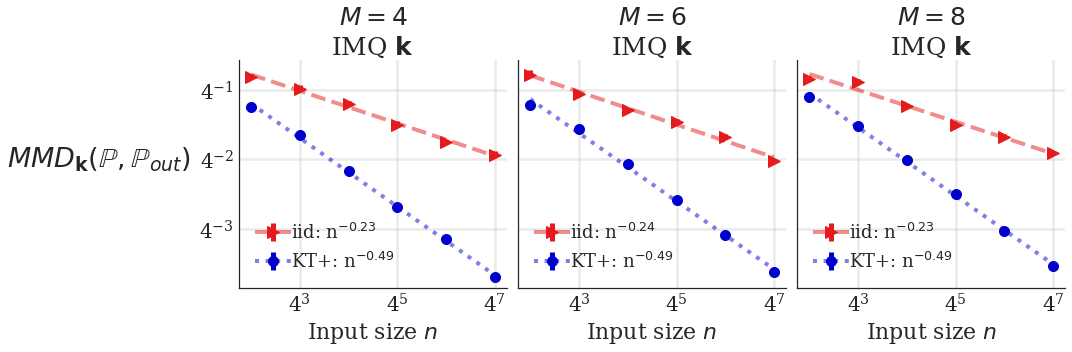

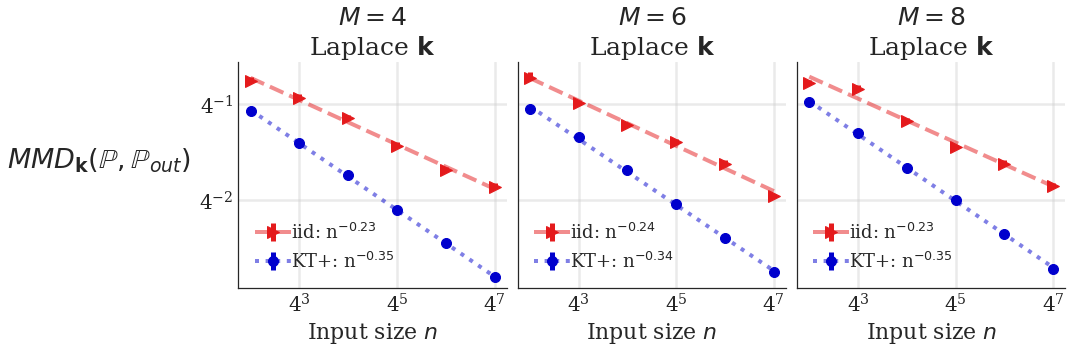

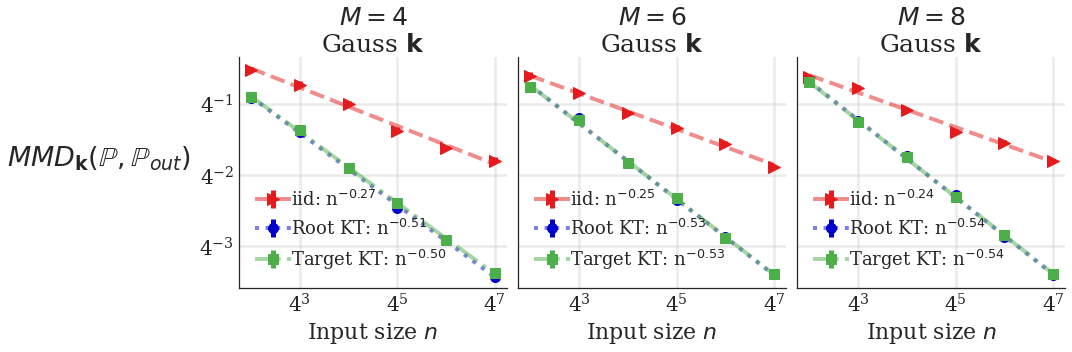

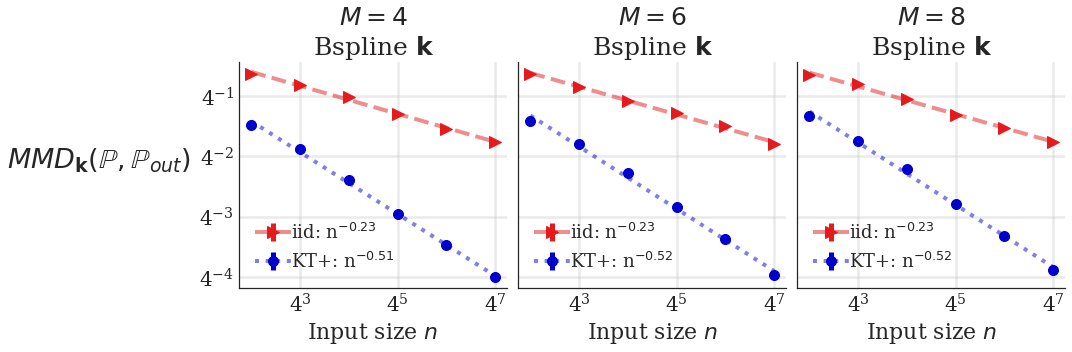

In [140]:
save_fig = True

for args.kernel, args.power, klabel in zip(["imq", "laplace", "gauss", "bspline"], [0.5, 0.70, 0.5, 0.67], ['IMQ', 'Laplace', 'Gauss', 'Bspline']):
# for args.kernel, args.power, klabel in zip(["gauss"], [0.5], ['Gauss']):

    for summary in [np.mean]:
        ylab = 'Mean Error' if summary == np.mean else 'Median Error'
        loc = 'lower left'
        leg_size = 18
        skip_ns = int(2)


        a = int(1)
        b = int(len(Ms))
        lss = ['--',  '-.',  ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
        mss = ['>',  's', 'o',  'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
        ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
        colors = ['#e41a1c', '#4daf4a', '#0000cd',  'black' , 'magenta']

        axes = plt.subplots(a, b, figsize=[5*b, 5*a], sharex=True, sharey=True)

        axes = axes[1].flatten() if a!=1 else axes[1] 
        for i, M in enumerate(Ms):
            ax = axes[i] #[i]
            lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
            mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
            ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
            colors = ['#e41a1c',   '#0000cd', '#4daf4a', 'black' , 'magenta']
            if args.kernel == "gauss":
                rm_keys = ["KT", "KT(rt)"]
                rm_keys = ["KT+"]
            elif args.kernel != "bspline":
                rm_keys = ["KT(rt)", 'KT(0.70)', 'KT'] # if args.kernel != "bspline" else []
            else:
                rm_keys = ["KT", "KT(0.67)"]
            plot_mmd_dict(ax, ms, mmd_results[f"mog-{args.kernel}-{M}"]["mmd_p"], 0.5, skip_ns=skip_ns, 
                          error_bar=True, legend_size=leg_size, summary=summary,
                         legend_loc=loc, rm_keys=rm_keys)
            ax.set_title(f'$M=%d$\n{klabel} $\\bf k$'%(M), fontsize=title_size)
            if i==0:
                ax.set_ylabel(mmd_labels[0], fontsize=ylab_size, rotation=0, labelpad=100)
            ax.set_xlabel(x_lab, fontsize=xlab_size)

        plt.tight_layout()
        if save_fig:
            plt.savefig(fig_dir+f"mog_{args.kernel}_no_kt.pdf")
        plt.show()





##  MoG 1 by 4

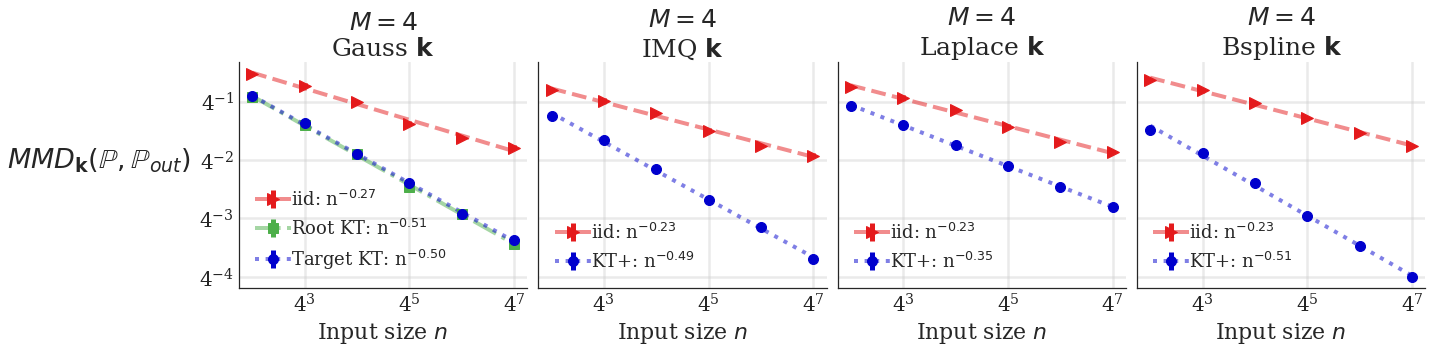

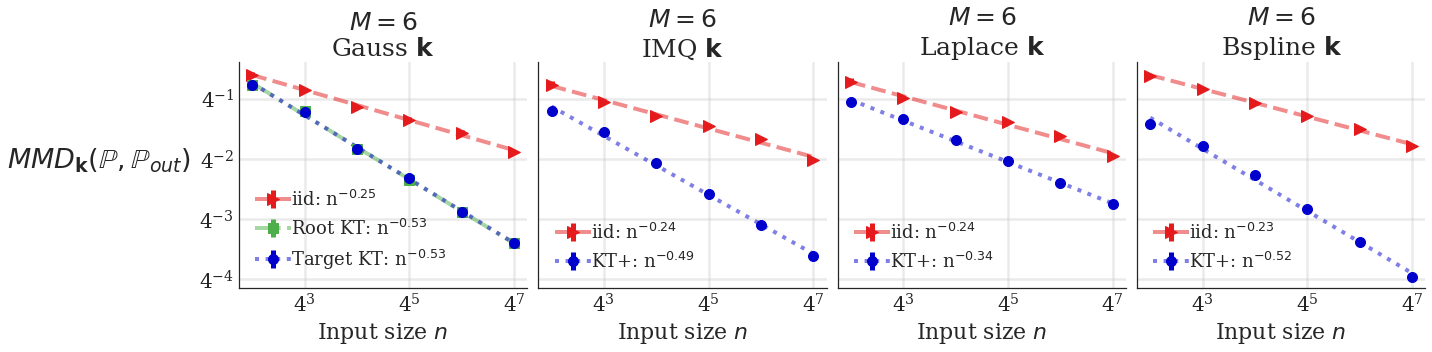

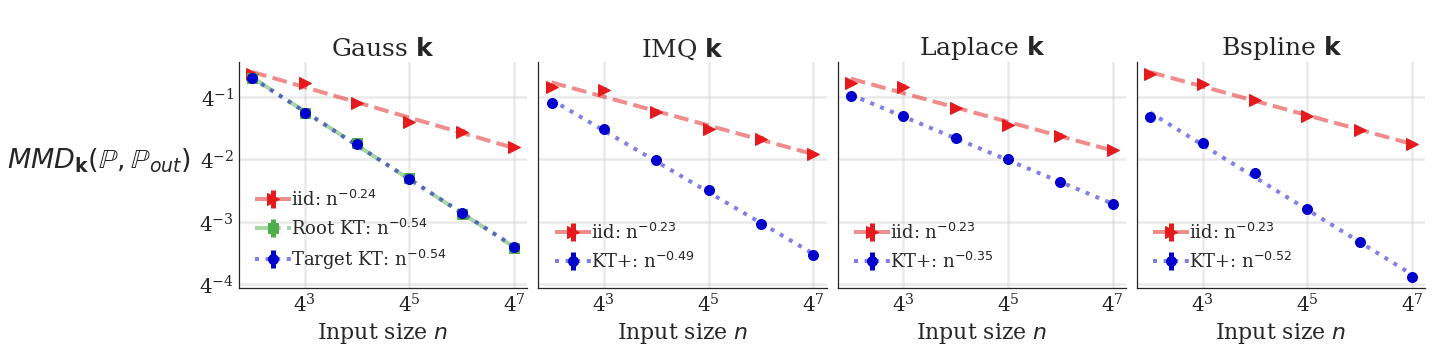

In [142]:
save_fig = True

jj = 0

a = int(1)
b = int(4)
lss = ['--',  '-.',  ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['>',  's', 'o',  'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
colors = ['#e41a1c', '#4daf4a', '#0000cd',  'black' , 'magenta']

for i, M in enumerate(Ms):
    jj = 0
    axes = plt.subplots(a, b, figsize=[5*b, 5*a], sharex=True, sharey=True)
    axes = axes[1].flatten() if a!=1 else axes[1] 
    for args.kernel, args.power, klabel in zip([ "gauss", "imq", "laplace","bspline"], [ 0.5, 0.5, 0.70, 0.67], ['Gauss',  'IMQ', 'Laplace', 'Bspline']):
    # for args.kernel, args.power, klabel in zip(["gauss"], [0.5], ['Gauss']):

        for summary in [np.mean]:
            ylab = 'Mean Error' if summary == np.mean else 'Median Error'
            loc = 'lower left'
            leg_size = 18
            skip_ns = int(2)

            

            ax = axes[jj] #[i]
            lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
            mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
            ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
            colors = ['#e41a1c',   '#0000cd', '#4daf4a', 'black' , 'magenta']
            if args.kernel == "gauss":
                rm_keys = ["KT+"]
                lss = ['--',  '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
                mss = ['>', 's', 'o',  'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']
                ms_size = [25, 20, 20,  20, 20, 20, 20, 20, 20, 20]
                colors = ['#e41a1c',   '#4daf4a', '#0000cd', 'black' , 'magenta']
            elif args.kernel != "bspline":
                rm_keys = ["KT(rt)", 'KT(0.70)', 'KT'] # if args.kernel != "bspline" else []
            else:
                rm_keys = ["KT", "KT(0.67)"]
            plot_mmd_dict(ax, ms, mmd_results[f"mog-{args.kernel}-{M}"]["mmd_p"], 0.5, skip_ns=skip_ns, 
                          error_bar=True, legend_size=leg_size, summary=summary, 
                         legend_loc=loc, rm_keys=rm_keys)
            title = f'\n{klabel} $\\bf k$'
            if M == 4 or M == 6:
                title = f'$M=%d$\n{klabel} $\\bf k$'%(M)
            ax.set_title(title, fontsize=title_size)
            ax.set_xlabel(x_lab, fontsize=xlab_size)
            jj += 1
            
        if jj==1:
            ax.set_ylabel(mmd_labels[0], fontsize=ylab_size, rotation=0, labelpad=100)


    plt.tight_layout()
    if save_fig:
#             plt.savefig(fig_dir+f"mog_{args.kernel}_all_kt.pdf")
        plt.savefig(fig_dir+f"mog_{args.kernel}_1_by_4_M{M}.pdf")
    plt.show()



